### Notebook to prepare datasets for use in networks

In [1]:
import os, sys, shutil
import numpy as np
import matplotlib.pyplot as plt
import torch 
import astropy.io.fits as fits
import scipy.ndimage as sndi
import sunpy.visualization.colormaps as cm
import cv2
sys.path.insert(0, '../utils')
#import data_utils

In [ ]:
''' 
NOTE: for DKIST, use n = 20 (e.g. 400 subsections per image) to have each subsection be around 2.3'' across (for MURaM set have 2.6'' across)
'''

#### Explore image transformations

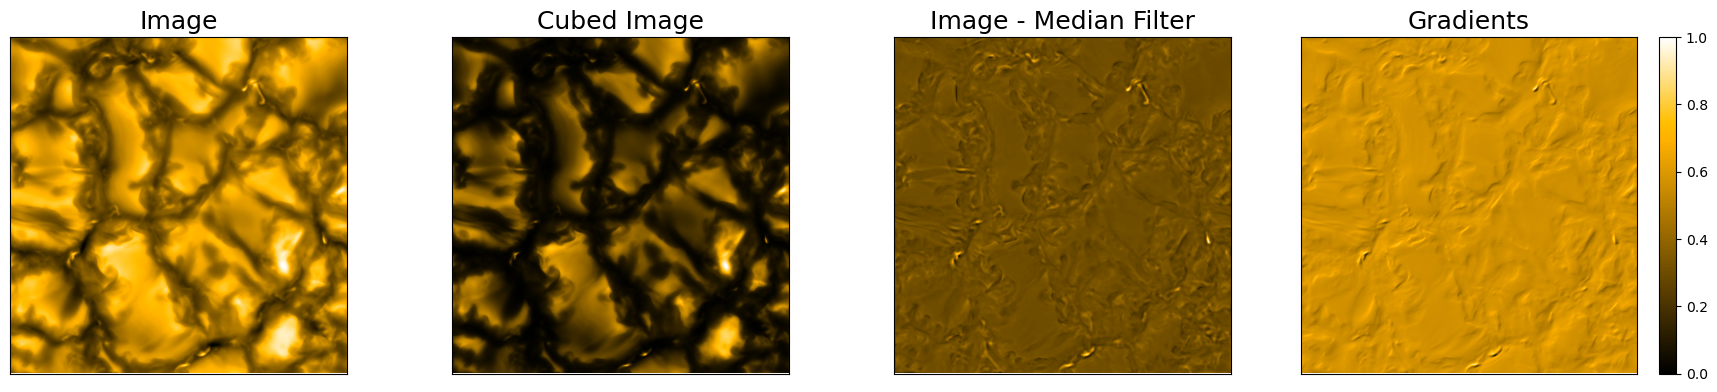

In [29]:
'''
Compare various transformations
'''
img = fits.open('../../Data/MURaM/fullNorm_I_out.000000.fits.gz')[0].data
fig, axs = plt.subplots(1, 4, figsize=(4.5*4, 1*4))
ts = 18
img_norm = (img - np.min(img))/(np.max(img)-np.min(img))
im0 = axs[0].imshow(img_norm, cmap=plt.get_cmap('goes-rsuvi171'), vmin=0, vmax=1); axs[0].set_title('Image', fontsize=ts)#; plt.colorbar(im0, ax=axs[0]);
img3_norm = (img**3 - np.min(img**3))/(np.max(img**3)-np.min(img**3))
im1 = axs[1].imshow(img3_norm, cmap=plt.get_cmap('goes-rsuvi171'), vmin=0, vmax=1); axs[1].set_title(r'Cubed Image', fontsize=ts)#; plt.colorbar(im1, ax=axs[1]);
med8 = sndi.median_filter(img, size=8)
medres_norm = ((img-med8) - np.min(img-med8))/(np.max(img-med8)-np.min(img-med8))
im2 = axs[2].imshow(medres_norm, cmap=plt.get_cmap('goes-rsuvi171'), vmin=0, vmax=1);  axs[2].set_title('Image - Median Filter', fontsize=ts)#; plt.colorbar(im2, ax=axs[2]);
grads = np.gradient(img)[0]+np.gradient(img)[1]
grads_norm = (grads - np.min(grads))/(np.max(grads)-np.min(grads))
im3 = axs[3].imshow(grads_norm, cmap=plt.get_cmap('goes-rsuvi171'), vmin=0, vmax=1); axs[3].set_title('Gradients', fontsize=ts)#; plt.colorbar(im3, ax=axs[3]);
for ax in axs.flat:
    ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
plt.colorbar(im3)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.0)

# k1 = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])/9 # blur (maybe useful?)
# k2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) # sharpening (probably not useful?)
# k3 = np.array([[-1, -1, -1], [-1, 8, -1],[-1, -1, -1]]) # edge detection (probably not useful?)
# f3 = cv2.filter2D(img, -1, k)

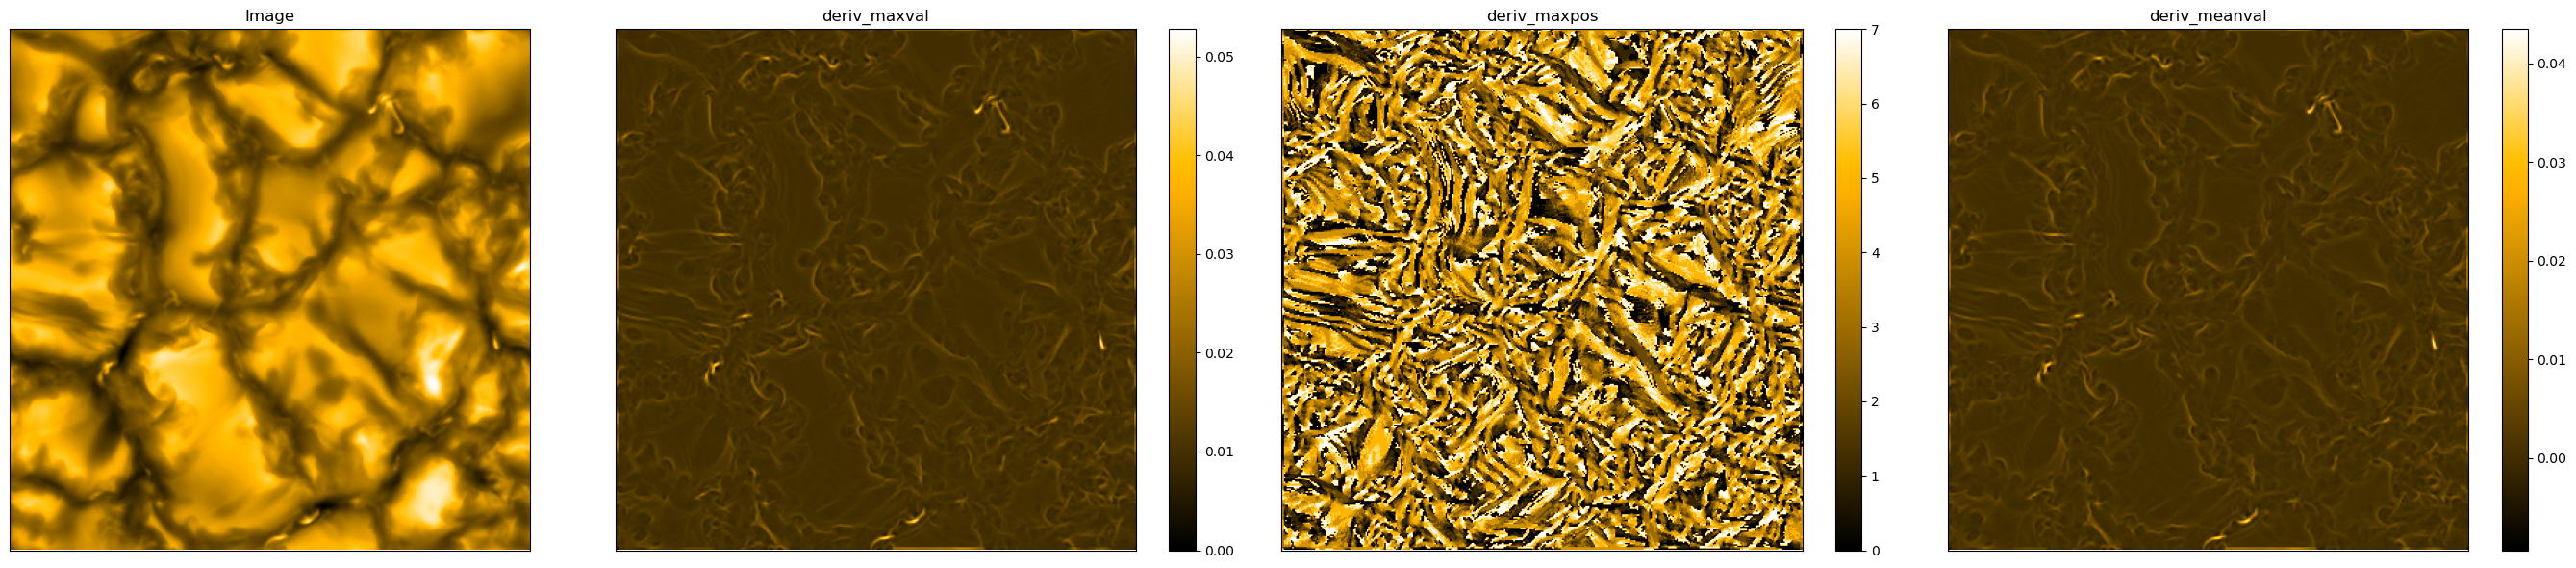

In [32]:
'''
Kevin's "madmax" function
'''
img = fits.open('../../Data/MURaM/fullNorm_I_out.000000.fits.gz')[0].data
deriv_maxval, _, deriv_meanval = data_utils.madmax(img) # for each pix, max/mean of the 8 2nd derives
fig, axs = plt.subplots(1, 3, figsize=(7*3, 1*6))
im0 = axs[0].imshow(img, cmap=plt.get_cmap('goes-rsuvi171')); axs[0].set_title('Image')
im1 = axs[1].imshow(deriv_maxval, cmap=plt.get_cmap('goes-rsuvi171')); axs[1].set_title('max 2nd derive'); plt.colorbar(im1, ax=axs[1])
im2 = axs[2].imshow(deriv_maxpos, cmap=plt.get_cmap('goes-rsuvi171')); axs[2].set_title('mean 2nd derive'); plt.colorbar(im2, ax=axs[2])
for ax in axs.flat:
    ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.001, hspace=0)

#### Break into subsections

In [ ]:
'''
Choose subsection size
 - For MURaM, did 128x128, so at 0.0211"/pix thats ~2.7"^2 per region
 - For these, 0.016"/pix, so 2.7"^2 is ~168x168pix
 - Maybe 170? Although closest potential im_size is 160 so lets do that (just must be divisible by 2, 5 times)
 - With pad=80, thats (4096-160)/160 = 3936/160 = 24.6 -> so I will get 24**2 sections. 
 - But can't do that cause needs to be square
    -- Ehh wait no it doesn't if I rewrite splitting code I will have some leftovers but thats fine
'''

img = fits.open(f'../Data/DKIST_gband_Oct28_series/VBI_46_29_333')[0].data
MuRAM_npy = np.load('../Data/UNetData_MURaM/images/train/000130__3.npy')
MuRAM_TS_npy = np.load('../Data/UNetData_MURaM_TSeries20/000130__2.npy')
DKIST_npy = np.load('../Data/UNetData_v2/images/train/VBI_00_12__0.npy')
fig, axs = plt.subplots(2,3, figsize=(12, 7))
axs[0,0].imshow(MuRAM_npy); axs[0,0].set_title(f'MURaM {np.shape(MuRAM_npy)} -> {np.shape(MuRAM_npy)[0]*0.0211}^2"')
axs[0,1].imshow(MuRAM_TS_npy); axs[0,1].set_title(f'MURaM TS {np.shape(MuRAM_TS_npy)} -> {np.shape(MuRAM_TS_npy)[0]*0.0211 }^2"')
axs[0,2].imshow(DKIST_npy); axs[0,2].set_title(f'DKIST {np.shape(DKIST_npy)} -> {np.shape(DKIST_npy)[0]*0.016}^2"')
s = [160, 170, 190]
for i in range(len(s)):
    axs[1,i].imshow(img[50:50+s[i],50:50+s[i]]); axs[1,i].set_title(f'{s[i]}x{s[i]} ({s[i]*0.016}^2")')

In [ ]:
'''
Break (jun 16) up images and segimages
Note that these images are much bigger, so break into 30**2 pieces not 15**2
'''
dir = "../Data/All_DKIST/"
imgoutdir = "../Data/UNetData_v2/images/"
segoutdir = "../Data/UNetData_v2/seg_images/" 
badtags = ['31_21', '33_13', '04_29', '17_20', '24_26']
files = [filename for filename in os.listdir(dir) if filename.startswith('VBI') and filename.endswith('_4096') and not any(tag in filename for tag in badtags)] 
n = 30 # sqrt of num pieces to break each image and seg image into
for file in files:
    print(file)
    tag = file[file.find('VBI'):-5]
    if os.path.exists(f'{imgoutdir}{tag}__224.npy'):
        # print(f'{imgoutdir}{tag}__224.npy exists')
        print(f'\tSubsections already saved')
    else:
        print(f'\tSaving subsections')
        data = fits.open(dir+file)[1].data
        print(dir+file)
        plt.figure(); plt.imshow(data, origin='lower')
        pad = int(np.shape(data)[0]/200)
        data = data[pad:-pad, pad:-pad]    ### NOTE: HANG ON DID I NOT HAVE THIS COMMENTED WHEN I RAN BEFORE?? WHY??
        segdata = np.squeeze(fits.open(dir+'SEGv2_'+file)[0].data)
        plt.figure(); plt.imshow(segdata[0:450,0:450], origin='lower')
        segdata = segdata[pad:-pad, pad:-pad] 
        plt.figure(); plt.imshow(segdata[0:450,0:450], origin='lower')
        N = np.min(np.shape(data)) 
        len = int(N/n) 
        num = 0
        for i in range(n):
            for j in range(n):
                name = tag+'__'+str(num); num += 1
                x1 = len * i
                x2 = len * (i + 1)
                y1 = len * j
                y2 = len * (j + 1)
                savedata = data[x1:x2, y1:y2]
                saveseg = segdata[x1:x2, y1:y2]
                plt.figure(); plt.imshow(savedata, origin='lower')
                plt.figure(); plt.imshow(saveseg, origin='lower')
                a=b
                np.save(imgoutdir+name, savedata)
                np.save(segoutdir+'SEG_'+name, saveseg) 

'''
Seperate into train and test folders 
'''
# imgdir = "../Data/UNetData_v2/images/"
# segdir = "../Data/UNetData_v2/seg_images/"
# imgfiles = [file for file in os.listdir(imgdir) if '.npy' in file]
# for imgfile in imgfiles:
#     label = imgfile[:-4]
#     segfile = [filename for filename in os.listdir(segdir) if label in filename][0]
#     folder = 'train' if np.random.rand(1)[0] < 0.7 else 'val'
#     shutil.move(imgdir+imgfile, imgdir+folder+'/'+imgfile)
#     shutil.move(segdir+segfile, segdir+folder+'/'+segfile)

'''
Check that npy files look ok
'''
# trainimgdir = "../Data/UNetData_v2/images/train/"
# trainsegdir = "../Data/UNetData_v2/seg_images/train/"
# trainimgs = os.listdir(trainimgdir)
# trainsegs = os.listdir(trainsegdir)
# for i in range(5):
#     idx = np.random.randint(0, len(trainimgs))
#     img = np.load(f'{trainimgdir}{trainimgs[idx]}')
#     seg = np.load(f'{trainsegdir}{trainsegs[idx]}')
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.set_title(f'{trainimgdir}{trainimgs[idx]}')
#     ax1.imshow(img)
#     ax2.imshow(seg)


In [ ]:
'''
Break up MURaM images and segimages
Note that these images are much smaller, so break into 5**2 pieces not 15**2
'''
# dir = "../Data/MURaM/"
# imgoutdir = "../Data/UNetData_MURaM/images/"
# segoutdir = "../Data/UNetData_MURaM/seg_images/" 
# files = [filename for filename in os.listdir(dir) if filename.startswith('SEGv2')] 
# n = 5 # sqrt of num pieces to break each image and seg image into
# for file in files:
#     print(file)
#     tag = file[file.find('I_out')+6: file.find('.fits')]
#     if os.path.exists(f'{imgoutdir}{tag}__{n**2-1}.npy'): # last .npy created from file
#         print(f'{imgoutdir}{tag}__{n**2-1}.npy exists')
#         print(f'\tSubsections already saved')
#     else:
#         print(f'\tSaving subsections')
#         data = fits.open(dir+file)[1].data 
#         segdata = np.squeeze(fits.open(dir+file)[0].data)
#         # Remove zero padding at edges of seg file
#         pad = int(np.shape(data)[0]/200)
#         data = data[pad:-pad, pad:-pad]
#         segdata = segdata[pad:-pad, pad:-pad] 
#         N = np.min(np.shape(data)) 
#         length = int(N/n) 
#         num = 0
#         for i in range(n):
#             for j in range(n):
#                 name = tag+'__'+str(num); num += 1
#                 x1 = length * i
#                 x2 = length * (i + 1)
#                 y1 = length * j
#                 y2 = length * (j + 1)
#                 savedata = data[x1:x2, y1:y2]
#                 saveseg = segdata[x1:x2, y1:y2]
#                 np.save(imgoutdir+name, savedata)
#                 np.save(segoutdir+'SEG_'+name, saveseg) 

'''
Seperate into img and seg folders 
'''
# imgdir = "../Data/UNetData_MURaM/images/"
# segdir = "../Data/UNetData_MURaM/seg_images/"
# imgfiles = [file for file in os.listdir(imgdir) if '.npy' in file]
# for imgfile in imgfiles:
#     label = imgfile[:-4]
#     segfile = [filename for filename in os.listdir(segdir) if label in filename][0]
#     folder = 'train' if np.random.rand(1)[0] < 0.7 else 'val'
#     # print(f'Moving {imgdir+imgfile} to {imgdir+folder}/{imgfile}')
#     # print(f'Moving {segdir+segfile} to {segdir+folder}/{segfile}')
#     shutil.move(imgdir+imgfile, imgdir+folder+'/'+imgfile)
#     shutil.move(segdir+segfile, segdir+folder+'/'+segfile)


'''
Check that npy files look ok
'''
# trainimgdir = "../Data/UNetData_MURaM/images/train/"
# trainsegdir = "../Data/UNetData_MURaM/seg_images/train/"
# trainimgs = os.listdir(trainimgdir)
# print(trainimgs)
# trainsegs = os.listdir(trainsegdir)
# for i in range(5):
#     idx = np.random.randint(0, len(trainimgs))
#     img = np.load(f'{trainimgdir}{trainimgs[idx]}')
#     seg = np.load(f'{trainsegdir}{trainsegs[idx]}')
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.set_title(f'{trainimgdir}{trainimgs[idx]}')
#     ax1.imshow(img)
#     ax2.imshow(seg)

In [ ]:
'''
Break up images and segimages (5**2 pieces maybe too small - lets do 3**2?)
And then seperate into train and val folders
'''
dir = "../Data/MURaM/"
imgoutdir = "../Data/UNetData_MURaM/images/"
segoutdir = "../Data/UNetData_MURaM/seg_images/" 
files = [filename for filename in os.listdir(dir) if filename.startswith('SEGv2')] 
n = 3 # sqrt of num pieces to break each image and seg image into
for file in files:
    print(file)
    tag = file[file.find('I_out')+6: file.find('.fits')]
    if os.path.exists(f'{imgoutdir}{tag}__{n**2-1}.npy'): # last .npy created from file
        print(f'{imgoutdir}{tag}__{n**2-1}.npy exists')
        print(f'\tSubsections already saved')
    else:
        print(f'\tSaving subsections')
        data = fits.open(dir+file)[1].data 
        segdata = np.squeeze(fits.open(dir+file)[0].data)
        # Remove area of im and seg where seg has zero padding 
        pad = int(np.shape(data)[0]/200)
        data = data[pad:-pad, pad:-pad]
        segdata = segdata[pad:-pad, pad:-pad] 
        N = np.min(np.shape(data)) 
        len = int(N/n) 
        num = 0
        for i in range(n):
            for j in range(n):
                name = tag+'__'+str(num); num += 1
                x1 = len * i
                x2 = len * (i + 1)
                y1 = len * j
                y2 = len * (j + 1)
                savedata = data[x1:x2, y1:y2]
                saveseg = segdata[x1:x2, y1:y2]
                np.save(imgoutdir+name, savedata)
                np.save(segoutdir+'SEG_'+name, saveseg) 

imgdir = "../Data/UNetData_MURaM/images/"
segdir = "../Data/UNetData_MURaM/seg_images/"
imgfiles = [file for file in os.listdir(imgdir) if '.npy' in file]
for imgfile in imgfiles:
    label = imgfile[:-4]
    segfile = [filename for filename in os.listdir(segdir) if label in filename][0]
    folder = 'train' if np.random.rand(1)[0] < 0.7 else 'val'
    # print(f'Moving {imgdir+imgfile} to {imgdir+folder}/{imgfile}')
    # print(f'Moving {segdir+segfile} to {segdir+folder}/{segfile}')
    shutil.move(imgdir+imgfile, imgdir+folder+'/'+imgfile)
    shutil.move(segdir+segfile, segdir+folder+'/'+segfile)

'''
Check that npy files look ok
'''

# print('Total file counts:')
# print(f'\tOriginal MURaM files: {len([filename for filename in os.listdir("../Data/MURaM") if filename.startswith("SEGv2") == False])}')
# print(f'\tTotal number segmented: {len([filename for filename in os.listdir("../Data/MURaM") if filename.startswith("SEGv2")])}')
# print(f'\tTotal number numpy pieces: {len(os.listdir("../Data/UNetData_MURaM/seg_images/train/")) + len(os.listdir("../Data/UNetData_MURaM/seg_images/val/"))}')
# print(f'\tTrain dir has {len(os.listdir("../Data/UNetData_MURaM/images/train/"))} images and {len(os.listdir("../Data/UNetData_MURaM/seg_images/train/"))} segs')
# print(f'\tVal dir has {len(os.listdir("../Data/UNetData_MURaM/images/val/"))} images and {len(os.listdir("../Data/UNetData_MURaM/seg_images/val/"))} segs')

# trainimgdir = "../Data/UNetData_MURaM/images/train/"
# trainsegdir = "../Data/UNetData_MURaM/seg_images/train/"
# trainimgs = os.listdir(trainimgdir)
# trainsegs = os.listdir(trainsegdir)
# for i in range(5):
#     idx = np.random.randint(0, len(trainimgs))
#     img = np.load(f'{trainimgdir}{trainimgs[idx]}')
#     seg = np.load(f'{trainsegdir}{trainsegs[idx]}')
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.set_title(f'{trainimgs[idx]}')
#     ax1.imshow(img)
#     ax2.imshow(seg)

In [ ]:
'''
MURaM mag data
'''

'''
Could I just cut them up the same way as for the flux series, put them in in "UNetData_[*]/mag_images", so that could access in dataloader just like I get the segs?
Would need to do for non T-series processed UNetData_MURaM, and the two T-series processed ones.
For now, lets focus on the non T-series one. 
'''

dir = '../Data/MURaM_mag/'
# files = [filename for filename in os.listdir(dir) if filename.startswith('tau')]
# magoutdir = '../Data/UNetData_MURaM/mag_images/'
# n = 3 # sqrt of num pieces to break each image into
# for file in files:
#     print(file)
#     tag = file[file.find('slice')+12: file.find('Bz')-1]
#     if os.path.exists(f'{magoutdir}{tag}__{n**2-1}.npy'): # last .npy created from file
#         print(f'{magoutdir}{tag}__{n**2-1}.npy exists')
#         print(f'\tSubsections already saved')
#     else:
#         print(f'\tSaving subsections')
#         magdata = fits.open(dir+file)[0].data 
#         # Remove zero padding at edges of seg file
#         pad = int(np.shape(magdata)[0]/200)
#         magdata = magdata[pad:-pad, pad:-pad]
#         N = np.min(np.shape(magdata)) 
#         length = int(N/n) 
#         num = 0
#         for i in range(n):
#             for j in range(n):
#                 name = tag+'__'+str(num); num += 1
#                 x1 = length * i
#                 x2 = length * (i + 1)
#                 y1 = length * j
#                 y2 = length * (j + 1)
#                 savemag = magdata[x1:x2, y1:y2]
#                 np.save(magoutdir+name, savemag)

'''
Seperate into train and test folders 
Oh wait but recall when I made UNetData_MURaM I had only segmented a subset of the files
And I did the rest to make the TSeries data, but didn't add them to the UNetData_MURaM/[images, seg_images]/[train,test] dataset
So if I want to use all of them for mag data, would need to train/test split the new UNetData_MURaM/* ones first (the one still in /images/)
But amount of training data seemed ok - wasn't imporving much with more data
So lets just add mags for the ones we already were using - leave the rest outside analogously 
'''

magdir = "../Data/UNetData_MURaM/mag_images/"
imgdir = "../Data/UNetData_MURaM/images/" # for checking which folder it should go in
magfiles = [file for file in os.listdir(magdir) if '.npy' in file]
for magfile in magfiles:
    imgfile = magfile # names are the same (xxxxx__x.npy)
    if os.path.exists(f'{imgdir}train/{imgfile}'): 
        shutil.move(magdir+magfile, magdir+'train/'+magfile)
    elif os.path.exists(f'{imgdir}val/{imgfile}'):
        shutil.move(magdir+magfile, magdir+'val/'+magfile)

#### Timeseries sets

In [ ]:
'''
Break up images and segimages
'''
imgdir = "../Data/UNetData_DKIST_TSeries/images/"
segdir = "../Data/UNetData_DKIST_TSeries/seg_images/" 
files = [filename for filename in os.listdir(dir) if filename.startswith('SEGv2')] # and not any(tag in filename for tag in bad) 
length = 160
n_regions = int(np.floor((np.shape(fits.open(f'../Data/DKIST_gband_Oct28_series/VBI_46_29_333')[0].data)[0]-2*pad)/length))**2
# if os.path.exists(imgdir) == False: os.mkdir(imgdir)
# if os.path.exists(segdir) == False: os.mkdir(segdir)
# for file in files:
#     print(file)
#     tag = file[file.find('VBI'):]
#     if os.path.exists(f'{imgdir}{tag}__{n_regions}.npy'): # last .npy created from file
#         print(f'{imgdir}{tag}__{n_regions}.npy exists')
#         print(f'\tSubsections already saved')
#     else:
#         print(f'\tSaving subsections')
#         data = fits.open(dir+file)[1].data 
#         segdata = np.squeeze(fits.open(dir+file)[0].data)
#         # Remove zero padding at edges of seg file
#         data = data[pad:-pad, pad:-pad]
#         segdata = segdata[pad:-pad, pad:-pad] 
#         # N = np.min(np.shape(data)) 
#         # length = int(N/n) 
#         num = 0
#         for i in range(int(np.sqrt(n_regions))):
#             for j in range(int(np.sqrt(n_regions))):
#                 name = tag+'__'+str(num); num += 1
#                 print(num)
#                 x1 = length * i
#                 x2 = length * (i + 1)
#                 y1 = length * j
#                 y2 = length * (j + 1)
#                 savedata = data[x1:x2, y1:y2]
#                 saveseg = segdata[x1:x2, y1:y2]
#                 # plt.figure(); plt.imshow(savedata, origin='lower')
#                 # plt.figure(); plt.imshow(saveseg, origin='lower')
#                 np.save(imgdir+name, savedata)
#                 np.save(segdir+'SEG_'+name, saveseg) 
# a=b

In [ ]:
'''
Choose n images per timeset
 - For MURaM dt=2, 3602(no..1801?) images, 384 x 384 (9 regions of 128x128)
        I did 40 imgs (80 sec) [TOO SHORT] giving ~90 sets per region, so ~810 total obs, and idk if that was enoughs
        What fi I try like 80 imgs (160 sec) even though that would only give like ~405 total obs???
 - For these dt=6, 200 images, 4096 x 4096 (24 regions of 160x160) 
        If did 20 (120 sec) giving ~10 sets per region thats ~240 total obs
        If did 15 (90 sec) giving ~13 sets per region thats ~312 total obs [WAY TO FEW OBS... BUT I GUESS I CAN TRY]
'''
size = 20

'''
Seperate into train and test, keeping sections together as cubes
'''

# imgfiles = [file for file in os.listdir(imgdir) if file.startswith('VBI')]
# segfiles = [file for file in os.listdir(segdir) if file.startswith('SEG')]
# if os.path.exists(f'{imgdir}train')==False: 
#     os.mkdir(f'{imgdir}train'); os.mkdir(f'{imgdir}val')
#     os.mkdir(f'{segdir}train'); os.mkdir(f'{segdir}val')
# for region in range(n_regions): # for each spatial region
#     imgfiles_region = [file for file in imgfiles if f"__{region}" in file]
#     segfiles_region = [file for file in segfiles if f"__{region}" in file]
#     start_step = 0
#     while start_step <= len(files)-size: # for each set of size imgs (there are 200 total)
#         if not any (tag in segfiles_region[start_step + int((size-1)/2)] for tag in bad): # if not in bad tags list
#             seg = np.load(f"{segdir}/{segfiles_region[start_step + int((size-1)/2)]}") # seg for the target image
#             imgfiles_set = imgfiles_region[start_step:start_step+size]
#             f1 = imgfiles_set[0]
#             f2 = imgfiles_set[-1]
#             imgsetname = f'{f1[4:6]}{f1[7:9]}{f1[10:13]}to{f2[4:6]}{f2[7:9]}{f2[10:13]}_{region}'
#             if (os.path.exists(f'{imgdir}train/{imgsetname}')==False) and (os.path.exists(f'{imgdir}val/{imgsetname}')==False):
#                 segname = f"SEG_{imgsetname}"
#                 imgset = np.zeros((size, seg.shape[0], seg.shape[1]))
#                 for i in range(size):
#                     imgset[i,:,:] = np.load(f"{imgdir}/{imgfiles_set[i]}")
#                 folder = 'train' if np.random.rand(1)[0] < 0.7 else 'val'
#                 np.save(f"{imgdir}{folder}/{imgsetname}", imgset)
#                 np.save(f"{segdir}{folder}/{segname}", seg)
#                 # plt.figure(); plt.imshow(imgset[10,:,:])
#                 # plt.figure(); plt.imshow(seg)
#                 start_step += size
# a = b


'''
Check that npy files look ok
'''
# trainimgdir = "../Data/UNetData_DKIST_TSeries/images/train/"
# trainsegdir = "../Data/UNetData_DKIST_TSeries/seg_images/train/"
# trainimgs = os.listdir(trainimgdir)
# print(trainimgs)
# trainsegs = os.listdir(trainsegdir)
# for i in range(5):
#     idx = np.random.randint(0, len(trainimgs))
#     img = np.load(f'{trainimgdir}{trainimgs[idx]}')
#     seg = np.load(f'{trainsegdir}{trainsegs[idx]}')
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.set_title(f'{trainimgs[idx]}[10]')
#     ax1.imshow(img[10,:,:])
#     ax2.imshow(seg)


'''
First step is to make normalized versions of all the og img sets (each og img normalized to [0-1]).
'''
#setparams = {'OG_dir':'../Data/All_DKIST/', 'startswith':'VBI', 'endswith':'_4096', 'bad':['31_21', '33_13', '04_29', '17_20', '24_26'], 'pos':1, 'unetdata_dir':'../Data/UNetData_v2/', 'n':30, 'pad':int(np.shape(fits.open(f"../Data/All_DKIST/VBI_00_12_4096")[1].data)[0]/200)}
setparams = {'OG_dir':'../Data/MURaM/' , 'startswith':'I', 'endswith':'', 'bad':[], 'pos':0, 'unetdata_dir':'../Data/UNetData_MURaM/', 'n':3, 'pad':int(np.shape(fits.open(f"../Data/MURaM/I_out.000000.fits.gz")[0].data)[0]/200)}
#setparams = {'OG_dir':'../Data/DKIST_gband_Oct28_series/' , 'startswith':'VBI', 'endswith':'', 'bad':[], 'pos':0, 'unetdata_dir':'../Data/UNetData_DKIST_TSeries/', 'n':, 'pad':}
OG_dir = setparams['OG_dir']; startswith = setparams['startswith']; endswith = setparams['endswith']; bad = setparams['bad']; pos = setparams['pos']; unetdata_dir = setparams['unetdata_dir']; n = setparams['n']; pad = setparams['pad']
# imgfiles = [file for file in os.listdir(OG_dir) if file.startswith(startswith) and file.endswith(endswith) and not any(tag in file for tag in bad)]
# print(f'Saving normalized versions of {len(imgfiles)} OG files')
# count = 0
# for imgfile in imgfiles:
#     img = fits.open(f"{OG_dir}{imgfile}")[pos].data
#     header = fits.open(f"{OG_dir}{imgfile}")[0].header
#     img_norm = (img - np.nanmin(img))/(np.nanmax(img) - np.nanmin(img))
#     hdu = fits.PrimaryHDU(img_norm)
#     hdu.writeto(f"{OG_dir}Norm_{imgfile}", overwrite=True)
#     count += 1
# print(f'Saved {count} files (now {len([file for file in os.listdir(OG_dir) if file.startswith("Norm")])} normed files)')
# a=b

'''
Now make subsections, analogously to for non-normed images
'''
normsubsecdir = f'{unetdata_dir}norm_images/'
# if os.path.exists(normsubsecdir) == False: os.mkdir(normsubsecdir)
# files = [file for file in os.listdir(OG_dir) if file.startswith('Norm')] # files = [fil for file in os.listdir(OG_dir) if file.startswith('Norm_VBI') and file.endswith('_4096') and not any(tag in file for tag in ['31_21', '33_13', '04_29', '17_20', '24_26'])]   
# for file in files:
#     print(file)
#     if 'MURaM' in outdir: tag = file[file.find('out')+4: file.find('.fits')]
#     else: tag = file[file.find('VBI'):-5]
#     if os.path.exists(f'{normsubsecdir}{tag}__{n**2-1}.npy'): # last .npy created from file
#         print(f'{normsubsecdir}{tag}__{n**2-1}.npy exists')
#         print(f'\tSubsections already saved')
#     else:
#         print(f'\tSaving subsections')
#         data = fits.open(f'{OG_dir}{file}')[0].data 
#         data = data[pad:-pad, pad:-pad] # Remove zero padding at edges of seg file
#         N = np.min(np.shape(data)) 
#         length = int(N/n) 
#         num = 0
#         for i in range(n):
#             for j in range(n):
#                 name = tag+'__'+str(num); num += 1
#                 x1 = length * i
#                 x2 = length * (i + 1)
#                 y1 = length * j
#                 y2 = length * (j + 1)
#                 savedata = data[x1:x2, y1:y2]
#                 np.save(normsubsecdir+name, savedata)
# normnpyfiles = [file for file in os.listdir(normsubsecdir) if '.npy' in file] # all files that aren't folders (train and test)
# oldnpyfiles = os.listdir(f"{outdir}/images/train")
# print(f'Saved {len(normnpyfiles)} total subsection npy files, each with shape {np.shape(np.load(f"{normsubsecdir}{normnpyfiles[0]}"))}')
# print(f'Make sure this matches the {len(os.listdir(f"{outdir}/images/train") + os.listdir(f"{outdir}/images/val"))} in old subsec dir, with shape {np.shape(np.load(f"{outdir}/images/train/{oldnpyfiles[0]}"))}') # no idea why there are a few more norm npy files for all_dkist... but shouldnt matter becasue just won't be moved to train and val folders right?
# a=b


In [8]:
import os
import numpy as np
print(len([f for f in os.listdir('../../Data/MURaM/') if f.startswith('I')]))
print(np.sort([f for f in os.listdir('../../Data/MURaM/') if f.startswith('I')])[0:23])

1801
['I_out.000000.fits.gz' 'I_out.000010.fits.gz' 'I_out.000020.fits.gz'
 'I_out.000030.fits.gz' 'I_out.000040.fits.gz' 'I_out.000050.fits.gz'
 'I_out.000060.fits.gz' 'I_out.000070.fits.gz' 'I_out.000080.fits.gz'
 'I_out.000090.fits.gz' 'I_out.000100.fits.gz' 'I_out.000110.fits.gz'
 'I_out.000120.fits.gz' 'I_out.000130.fits.gz' 'I_out.000140.fits.gz'
 'I_out.000150.fits.gz' 'I_out.000160.fits.gz' 'I_out.000170.fits.gz'
 'I_out.000180.fits.gz' 'I_out.000190.fits.gz' 'I_out.000200.fits.gz'
 'I_out.000210.fits.gz' 'I_out.000220.fits.gz']


In [7]:
'''
Luckily, looks like I've saved the npy sections in UNetData_MURaM with tags included 
- Although not all target imgs will have +/- 21 imgs on either side, since split into train/val randomly
So make UNetData_MURaM_TSeries
LETS TRY INCLUDING 20 IM TOTAL, SO 10 ON EITHER SIDE (might need to change to 20 on either side)
- Fist copy all of muram npy into one folder
- Then, for each spatial section
    Take each set of 20 imgs, assign to images/train or images/test
    Take corresponding 20 segs, assigned to seg_images/train or seg_images/test
NOTE: looks like I didnt actually segment all of them previously (only like 300)
- Now ive added the others (e.g. to ../Data/MURaM/SEGv2[*])
- And added the npy segments to ../Data/UNetData_MURaM/images/[*].npy and ../Data/UNetData_MURaM/seg_images/SEGv2_[*].npy
- BUT note that I have NOT seperated them into train and test folders - so when I used dataloader with UNetData_MURaM its smaller set. 
'''

# # Make new dirctories and copy all the npy imgs and segs from UNetData_MURaM
# size = 81 #41 # 40 should have 41 imgs per set
# fromparent = "../../Data/UNetData_MURaM" 
# newparent = f"{fromparent}_TSeries{size-1}"  # shutil.rmtree(parentdir)

# for dir in [newparent,f"{newparent}/norm_images",f"{newparent}/norm_images/train",f"{newparent}/norm_images/val",f"{newparent}/seg_images",f"{newparent}/seg_images/train",f"{newparent}/seg_images/val"]:
#     if os.path.exists(dir)==False: os.mkdir(dir)
# imgdir = f"{fromparent}/norm_images"; trnimgdir = f"{imgdir}/train"; tstimgdir = f"{imgdir}/val"
# segdir = f"{fromparent}/seg_images"; trnsegdir = f"{segdir}/train"; tstsegdir = f"{segdir}/val"
# all_muram_npy = [f"{trnimgdir}/{filename}" for filename in os.listdir(trnimgdir)] + [f"{trnsegdir}/{filename}" for filename in os.listdir(trnsegdir)] + [f"{tstimgdir}/{filename}" for filename in os.listdir(tstimgdir)] +  [f"{tstsegdir}/{filename}" for filename in os.listdir(tstsegdir)] + [f"{imgdir}/{filename}" for filename in os.listdir(imgdir) if filename.endswith('.npy')] + [f"{segdir}/{filename}" for filename in os.listdir(segdir) if filename.endswith('.npy')]
# print(len(all_muram_npy))
# for path in all_muram_npy:
#     file = path[path.rfind('/')+1:]
#     if os.path.exists(f"{newparent}/{file}") == False:
#         shutil.copy(path, f"{newparent}/{file}")

#Split into img and seg and train and test, keeping sections together as cubes
imgfiles = [file for file in os.listdir(newparent) if '.npy' in file and ('SEG' in file)==False]
segfiles = [file for file in os.listdir(newparent) if '.npy' in file and ('SEG' in file)==True]
imgdir = f"{newparent}/norm_images"
segdir = f"{newparent}/seg_images"
print(len(imgfiles))
for region in range(9): # for each spatial region
    print(region)
    imgfiles_region = [file for file in imgfiles if f"__{region}" in file]
    segfiles_region = [file for file in segfiles if f"__{region}" in file]
    start_step = 0
    while start_step <= 1801-size: # for each set of size imgs (there are 1801 total)
        seg = np.load(f"{newparent}/{segfiles_region[start_step + int((size-1)/2)]}") # seg for the target image
        imgfiles_set = imgfiles_region[start_step:start_step+size]
        imgset = np.zeros((size, seg.shape[0], seg.shape[1]))
        for i in range(size):
            imgset[i,:,:] = np.load(f"{newparent}/{imgfiles_set[i]}") # if load error, just try re-copying that file
        folder = 'train' if np.random.rand(1)[0] < 0.7 else 'val'
        imgsetname = f"{imgfiles_set[0][0:-7]}to{imgfiles_set[-1][0:-7]}_{region}"
        segname = f"SEG_{imgsetname}"
        np.save(f"{newparent}/norm_images/{folder}/{imgsetname}", imgset)
        np.save(f"{newparent}/seg_images/{folder}/{segname}", seg)
        start_step += size
for file in [file for file in os.listdir(newparent) if '.npy' in file]:
    os.remove(f"{newparent}/{file}")
print(f'New time series set {newparent} has {len(os.listdir(newparent+"/norm_images/train"))} training obs and {len(os.listdir(newparent+"/norm_images/val"))} test obs')

16209
0
1
2
3
4
5
6
7
8
New time series set ../../Data/UNetData_MURaM_TSeries80 has 164 training obs and 72 test obs


In [6]:
# for f in imgfiles:
#     try: np.load(f'{newparent}/{f}')
#     except ValueError:print(f'Cant load {f}')
shutil.copy('../../Data/UNetData_MURaM/norm_images/val/003420__3.npy',f'{newparent}/003420__3.npy')
        

'../../Data/UNetData_MURaM_TSeries80/003420__3.npy'

109
72


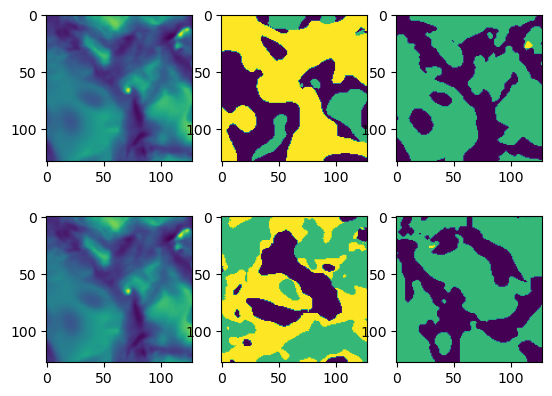

In [18]:
ts40testfiles =[f for f in os.listdir('../../model_runs_seg/MURaM/WNetT_1C/test_preds_MURaM/') if 'true_' in f]
print(len(ts40testfiles))
ts80testfiles =[f for f in os.listdir('../../model_runs_seg/MURaM/WNetT_2C/test_preds_MURaM/') if 'true_' in f]
print(len(ts80testfiles))
for f80 in ts80testfiles:
    im80 = np.load(f'../../model_runs_seg/MURaM/WNetT_2C/test_preds_MURaM/{f80}')#[2] # targ idx is 2 for both (both are 5 long)
    for f40 in ts40testfiles:
        im40 = np.load(f'../../model_runs_seg/MURaM/WNetT_1C/test_preds_MURaM/{f40}')#[2]
        if np.all(im80 == im40):
            print(f'{f40} from TS40 set matches {f80} from TS80 set')
            a=b
fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(np.load(f'../../model_runs_seg/MURaM/WNetT_1C/test_preds_MURaM/x_39.npy')[2])
axs[0,1].imshow(np.load(f'../../model_runs_seg/MURaM/WNetT_1C/test_preds_MURaM/pred_39.npy'))
axs[0,2].imshow(np.load(f'../../model_runs_seg/MURaM/WNetT_1C/test_preds_MURaM/true_39.npy'))
axs[1,0].imshow(np.load(f'../../model_runs_seg/MURaM/WNetT_2C/test_preds_MURaM/x_38.npy')[2])
axs[1,1].imshow(np.load(f'../../model_runs_seg/MURaM/WNetT_2C/test_preds_MURaM/pred_38.npy'))
axs[1,2].imshow(np.load(f'../../model_runs_seg/MURaM/WNetT_2C/test_preds_MURaM/true_38.npy'))

72


IndexError: list index out of range

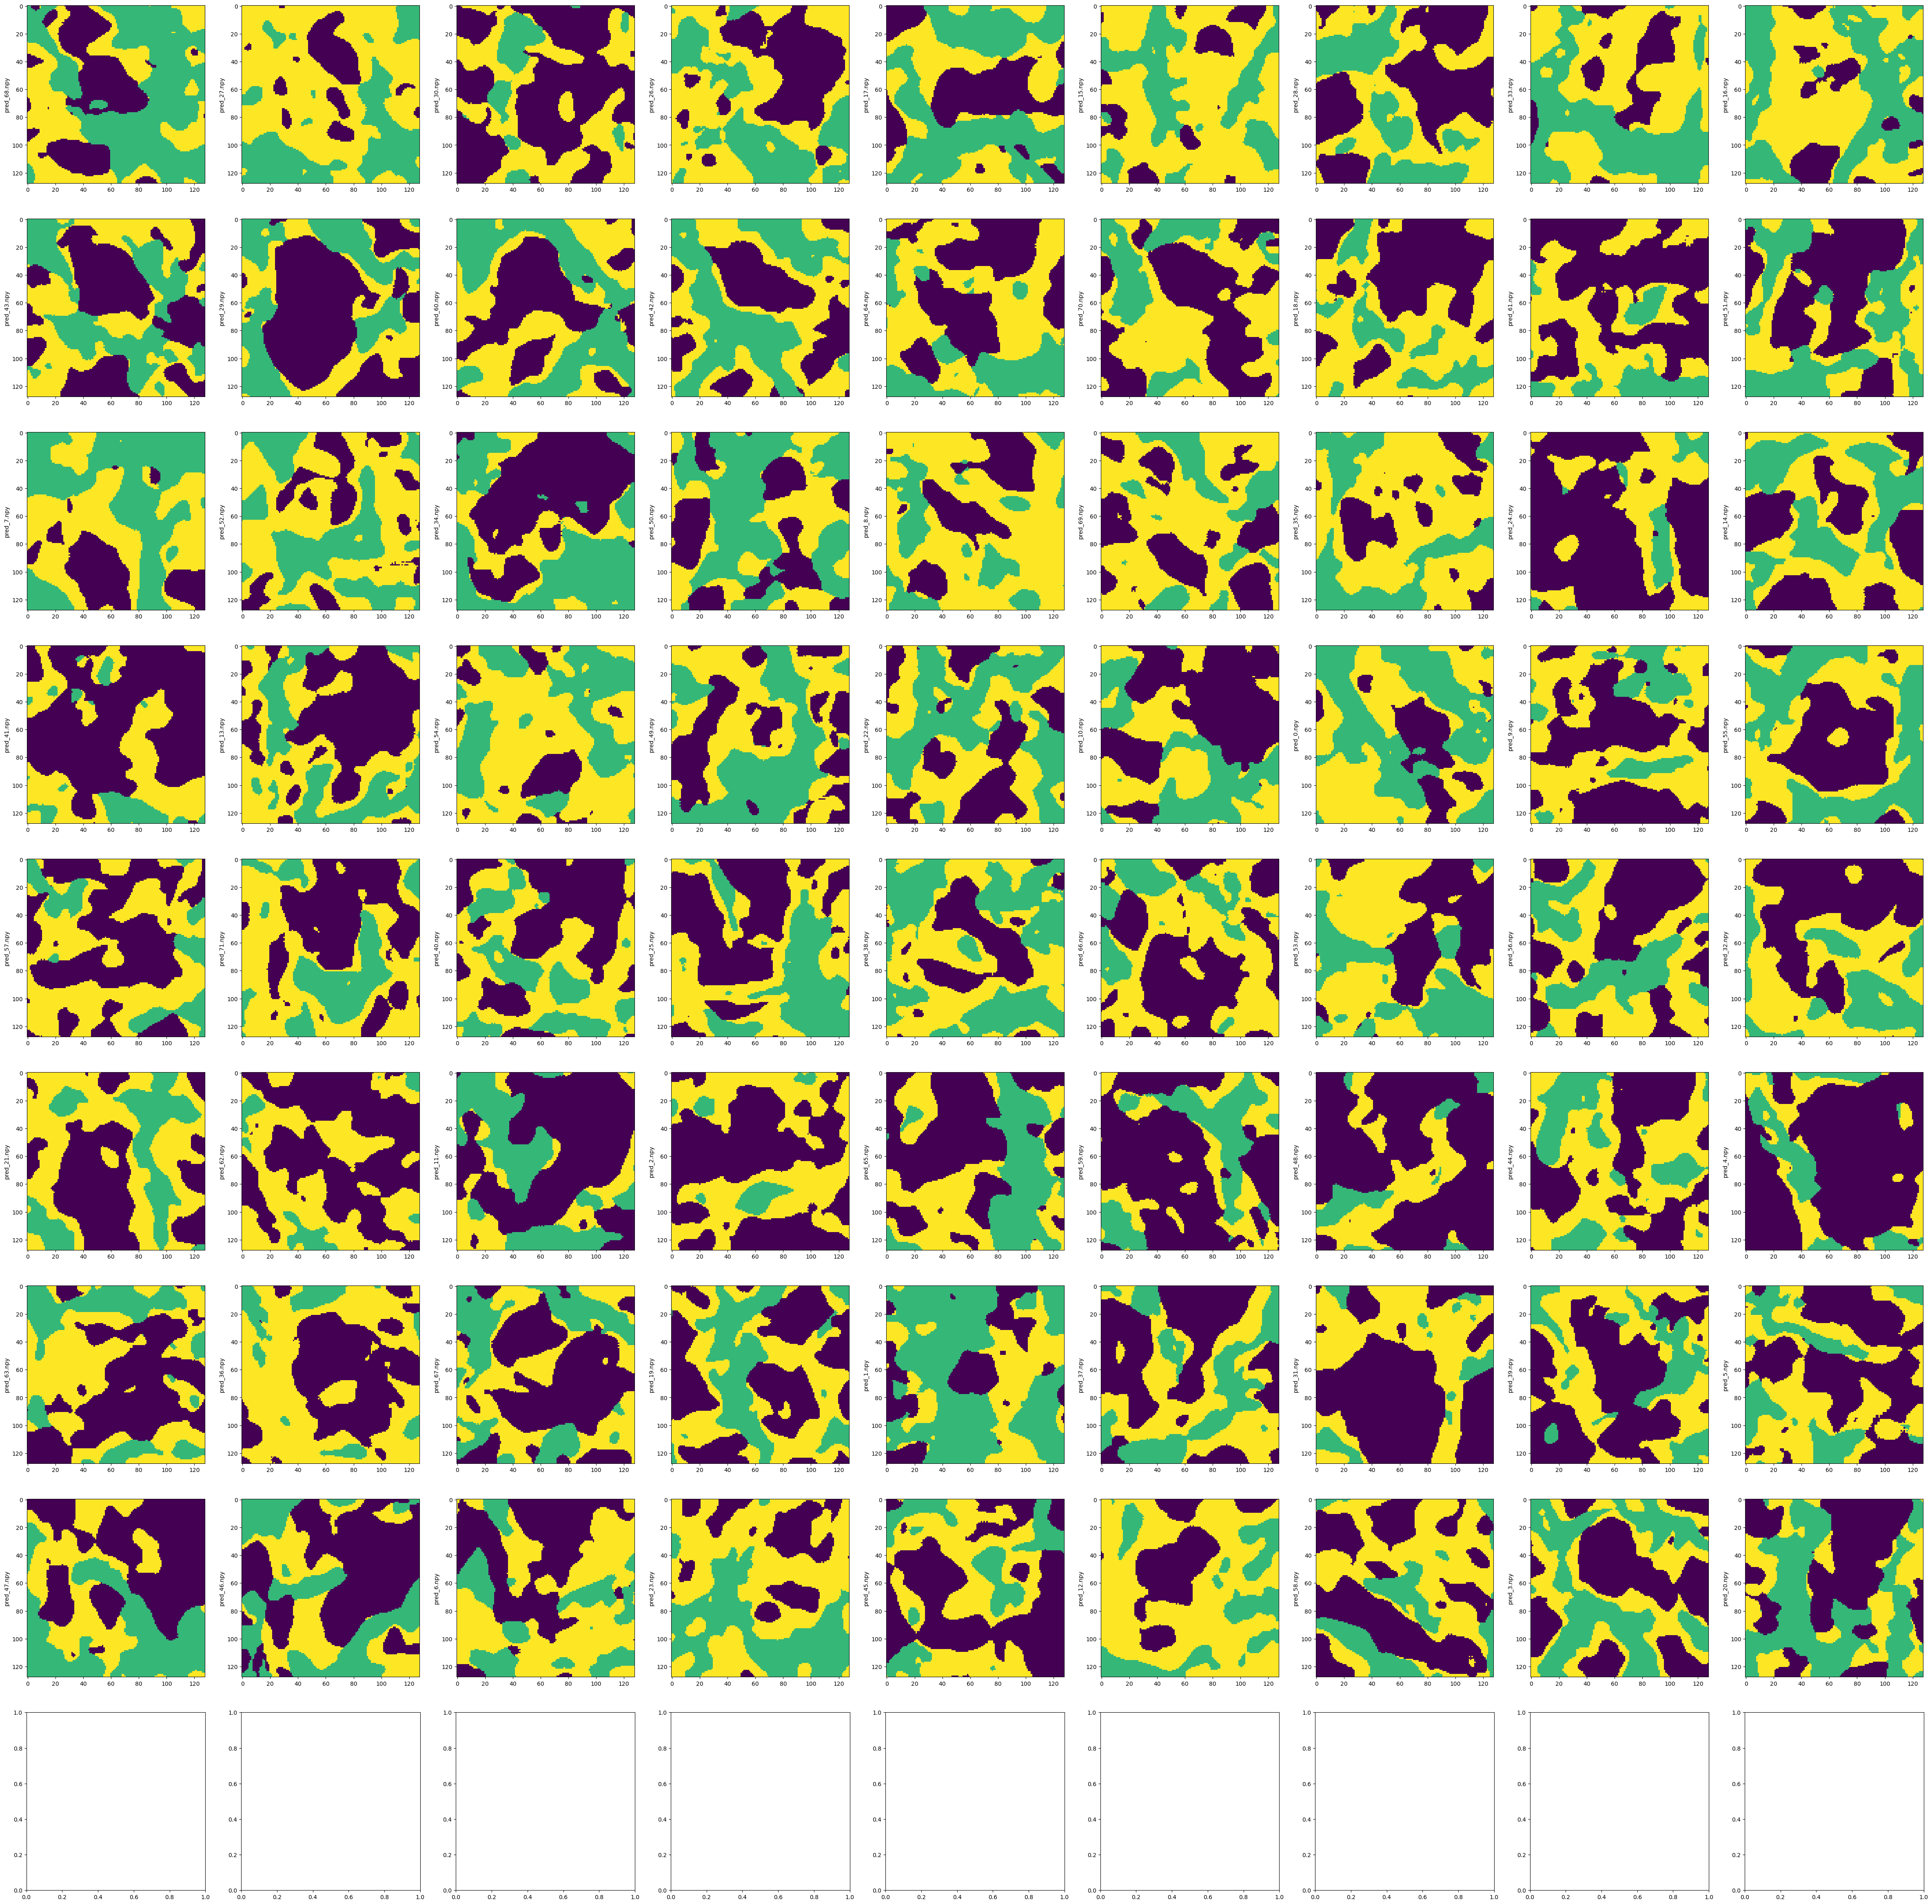

In [20]:
ts80testfiles =[f for f in os.listdir('../../model_runs_seg/MURaM/WNetT_2C/test_preds_MURaM/') if 'pred_' in f]
print(len(ts80testfiles))
fig, axs = plt.subplots(9, 9, figsize=(60, 60))
idx = 0
for i in range(9):
    for j in range(9):
        f80 = ts80testfiles[idx]; idx+=1
        im80 = np.load(f'../../model_runs_seg/MURaM/WNetT_2C/test_preds_MURaM/{f80}')
        axs[i, j].imshow(im80); axs[i,j].set_ylabel(f80)
for ax in axs.flat:
    ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.01)

#### Redo with proper normalization

In [60]:
'''
[7/24] Make UNetData_MURaM_TSeries*/norm_images
    - Make sure to keep correspondence with UNetData_MURaM_TSeries*/seg_images (tags must indicate the same image, and TTS must be the same)
'''

# Make new dirctories for normed TSeries data 
size = 21 # 40 should have 41 imgs per set
parent = f"../../Data/UNetData_MURaM_TSeries{size-1}"  
imgdir = f"{parent}/norm_images"; trnimgdir = f"{imgdir}/train"; tstimgdir = f"{imgdir}/val"; #segdir = f"{fromparent}/seg_images"; trnsegdir = f"{segdir}/train"; tstsegdir = f"{segdir}/val"
for dir in [imgdir, trnimgdir, tstimgdir]:
    if os.path.exists(dir)==False: 
        os.mkdir(dir)
        
# Temporarily copy all normed npy subsections into UNetData_*_TSeries*/norm_images/ [include parent dir in case some not in train or val] 
all_muram_norm_npy = [f"../../Data/UNetData_MURaM/norm_images/{f}" for f in os.listdir("../../Data/UNetData_MURaM/norm_images") if '.npy' in f] + [f"../../Data/UNetData_MURaM/norm_images/train/{f}" for f in os.listdir("../../Data/UNetData_MURaM/norm_images/train")] + [f"../../Data/UNetData_MURaM/norm_images/val/{f}" for f in os.listdir("../../Data/UNetData_MURaM/norm_images/val")]
for path in all_muram_norm_npy:
    file = path[path.rfind('/')+1:]
    shutil.copy(path, f"{parent}/norm_images/{file}") #     if os.path.exists(f"{parent}/norm_images/{file}") == False:

# Split imgs into and train and test based on seg location, keeping sections together as cubes
imgfiles = [file for file in os.listdir(f"{parent}/norm_images") if '.npy' in file]; #segfiles = [file for file in os.listdir(newparent) if '.npy' in file and ('SEG' in file)==True]
shape = np.load(f"../../Data/UNetData_MURaM/images/train/000130__3.npy").shape # example image 
for region in range(9): # for each spatial region
    imgfiles_region = np.sort([file for file in imgfiles if f"__{region}" in file]); # segfiles_region = [file for file in segfiles if f"__{region}" in file]
    start_step = 0
    while start_step <= 1801-size: # for each set of size imgs (there are 1801 total)
        #seg = np.load(f"{newparent}/{segfiles_region[start_step + int((size-1)/2)]}") # seg for the target image
        imgfiles_set = imgfiles_region[start_step:start_step+size]
        imgset = np.zeros((size, shape[0], shape[1]))
        for i in range(size):
            imgset[i,:,:] = np.load(f"{parent}/norm_images/{imgfiles_set[i]}") # BUT HOW DID I KNOW THIS WOULD BE IN ORDER WITHOUT SORTING IVE NOW APPLIED ABOVE TO IMGFILES_REGION??
        imgsetname = f"{imgfiles_set[0][0:-7]}to{imgfiles_set[-1][0:-7]}_{region}"
        segname = f"SEG_{imgsetname}.npy"
        if segname in os.listdir(f"../../Data/UNetData_MURaM_TSeries{size-1}/seg_images/train/"): 
            folder = 'train'
        elif segname in os.listdir(f"../../Data/UNetData_MURaM_TSeries{size-1}/seg_images/val/"):
            folder = 'val'
        else:
            raise ValueError(f'Corresponding segmented image {segname} not found')
        np.save(f"{parent}/norm_images/{folder}/{imgsetname}", imgset); # np.save(f"{newparent}/SEG_images/{folder}/{segname}", seg)
        start_step += size   
# for file in [file for file in os.listdir(parent) if '.npy' in file]:
#     os.remove(f"{parent}/norm_images/{file}")

# Checks
if len(os.listdir(f'{parent}/images/train')) == len(os.listdir(f'{parent}/seg_images/train')) == len(os.listdir(f'{parent}/norm_images/train')):
    print('Good! Train directories that should correpond match in length')
if len(os.listdir(f'{parent}/images/val')) == len(os.listdir(f'{parent}/seg_images/val')) == len(os.listdir(f'{parent}/norm_images/val')):
    print('Good! Test directories that should correpond match in length')
fig, axs = plt.subplots(3,2, figsize=(7, 10))
normingsets = os.listdir(f"../../Data/UNetData_MURaM_TSeries{size-1}/norm_images/train")
for i in range(3):
    idx = int(np.random.choice(np.linspace(0,len(normingsets),len(normingsets))))
    normimgset = np.load(f"../../Data/UNetData_MURaM_TSeries{size-1}/norm_images/train/{normingsets[idx]}")
    imgset = np.load(f"../../Data/UNetData_MURaM_TSeries{size-1}/images/train/{normingsets[idx]}") 
    im0 = axs[i,0].imshow(imgset[2]); plt.colorbar(im0, ax=axs[i,0])
    im1 = axs[i,1].imshow(normimgset[2]); plt.colorbar(im1,  ax=axs[i,1])
axs[0,0].set_title('non-normed')
axs[0,1].set_title('normed')
### OY SAME SCALE!! NOT NORMED!!
    
    

ValueError: Corresponding segmented image SEG_000000to000200_0.npy not found

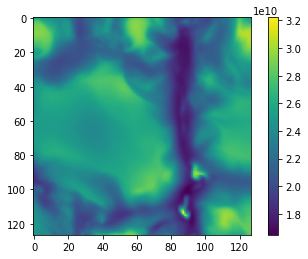

In [56]:
# norm_images = os.listdir('../../Data/UNetData_MURaM/norm_images/')
# im = np.load(f'../../Data/UNetData_MURaM/norm_images/{norm_images[0]}')
# plt.imshow(im)
# plt.colorbar()

# all_muram_norm_npy = [f"../../Data/UNetData_MURaM/norm_images/{f}" for f in os.listdir("../../Data/UNetData_MURaM/norm_images") if '.npy' in f] + [f"../../Data/UNetData_MURaM/norm_images/train/{f}" for f in os.listdir("../../Data/UNetData_MURaM/norm_images/train")] + [f"../../Data/UNetData_MURaM/norm_images/val/{f}" for f in os.listdir("../../Data/UNetData_MURaM/norm_images/val")]
# for file in all_muram_norm_npy:
#     im = np.load(f'{file}')
#     if np.nanmin(im) < 0 or np.nanmax(im) > 1:
#         print(f'File {file} is not properly normalized')
   
norm_imgsets = os.listdir('../../Data/UNetData_MURaM_TSeries40/norm_images/train/')
imset = np.load(f'../../Data/UNetData_MURaM_TSeries40/norm_images/train/{norm_imgsets[0]}')
plt.imshow(imset[1])
plt.colorbar()



#### Median filtering

Text(0.5, 1.0, 'residual')

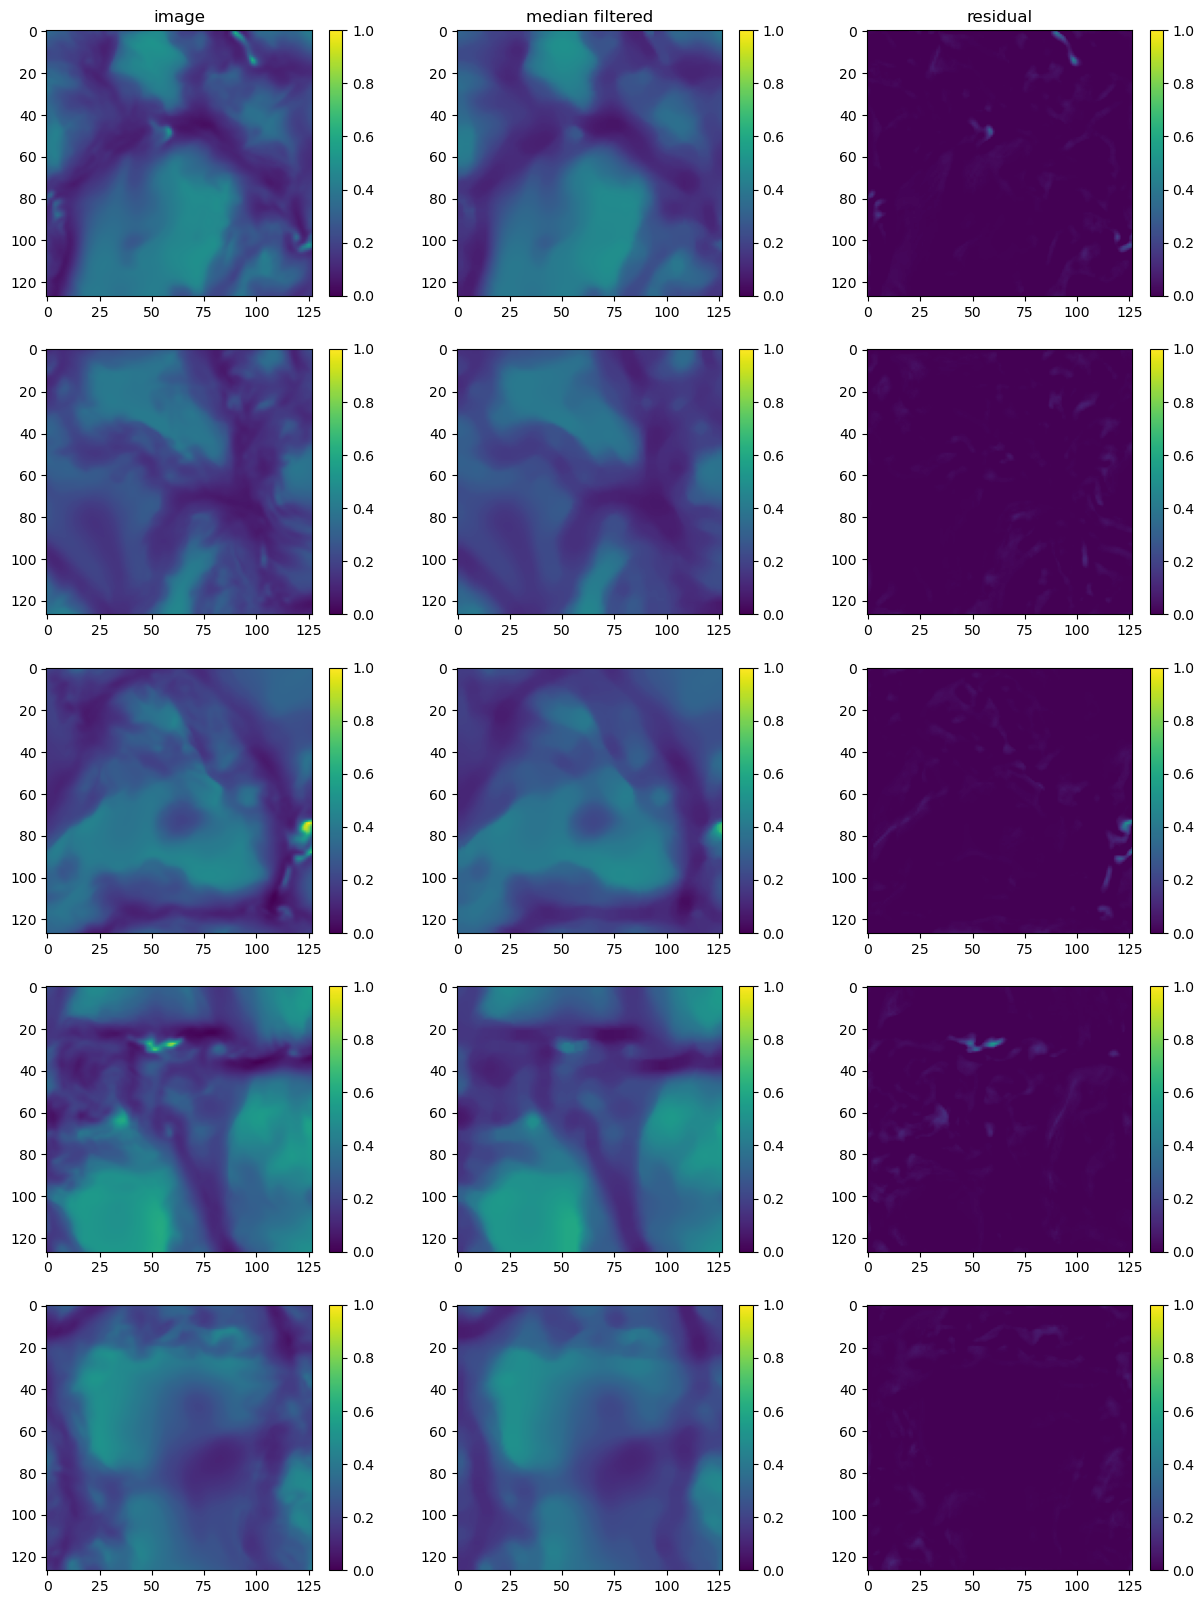

In [14]:

'''
Now make med8 
'''

# os.mkdir(f'{unetdata_dir}med8_images'); os.mkdir(f'{unetdata_dir}med8_images/train')
# for img in os.listdir(f'{unetdata_dir}images/train/'):
#     # data = np.load(f'{unetdata_dir}images/train/{img}') # data = (data - np.nanmin(data))/(np.nanmax(data) - np.nanmin(data))
#     data = np.load(f'{unetdata_dir}norm_images/train/{img}') # why was I using non-norm and then normalizing individual image? isnt that what I was tyring to aviod???
#     med = sndi.median_filter(data, size=8)
#     name = f'med8_{img}'
#     np.save(f'{unetdata_dir}/med8_images/train/{name}', med)

'''
Test that med and med residual looks usefull
'''
unetdata_dir = '../../Data/UNetData_MURaM/'
imgs = os.listdir(f'{unetdata_dir}norm_images/train/')
meds = os.listdir(f'{unetdata_dir}med8_images/train/')
fig, axs = plt.subplots(5, 3, figsize=(15, 20))
for i in range(5):
    idx = np.random.randint(0, 100)
    img = np.load((f'{unetdata_dir}norm_images/train/{imgs[idx]}'))
    med = np.load((f'{unetdata_dir}med8_images/train/med8_{imgs[idx]}'))
    im = axs[i,0].imshow(img, vmin=0, vmax=1); plt.colorbar(im, ax = axs[i,0])
    im = axs[i,1].imshow(med, vmin=0, vmax=1); plt.colorbar(im, ax = axs[i,1])
    im = axs[i,2].imshow(img-med, vmin=0, vmax=1); plt.colorbar(im, ax = axs[i,2])#, vmin=0, vmax=1)
axs[0,0].set_title('image')
axs[0,1].set_title('median filtered')
axs[0,2].set_title('residual')

In [37]:
'''
Find min and max of img-med8 for full sequence (should be fine to just use train)
'''

# trn_files = os.listdir('../../Data/UNetData_MURaM/fullnorm_med8_images/train/')
# mins = []; maxs = []
# for f in trn_files:
#     med8 = np.load(f'../../Data/UNetData_MURaM/fullnorm_med8_images/train/{f}')
#     img = np.load(f'../../Data/UNetData_MURaM/fullnorm_images/train/{f.replace("med8_","")}')
#     res = img - med8
#     mins.append(np.min(res.flatten()))
#     maxs.append(np.max(res.flatten()))
print(np.min(mins), np.max(maxs))

-0.28187524981389467 0.6923868874830774


#### Check final datasets and loaders

In [4]:
'''
Sizes
'''
muram_npy = np.load('../../Data/UNetData_MURaM/norm_images/000440__2.npy')
dkist_npy = np.load('../../Data/UNetData_v2/norm_images/VBI_51_1__542.npy')
print(muram_npy.shape)
print(dkist_npy.shape)


(127, 127)
(131, 131)


In [ ]:
'''
Check that MURaM datasets match up looks ok
'''
trnimgs = os.listdir('../../Data/UNetData_MURaM/images/train')

# They do match up
n = 5
idxs = np.random.choice(np.linspace(0, len(trnimgs)-1, len(trnimgs)-1, dtype=int),n)
fig, axs = plt.subplots(n, 3, figsize=(10, n*3))
for i in range(n):
    img = np.load(f'../../Data/UNetData_MURaM/images/train/{trnimgs[idxs[i]]}')
    mag = np.load(f'../../Data/UNetData_MURaM/mag_images/train/{trnimgs[idxs[i]]}')
    seg = np.load(f'../../Data/UNetData_MURaM/seg_images/train/SEG_{trnimgs[idxs[i]]}')
    axs[i,0].imshow(img)
    axs[i,1].imshow(mag)
    axs[i,2].imshow(seg)
    print(f'img {img.shape}, mag {mag.shape}, seg {seg.shape}')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)


Searching through 810 images for match
DONE


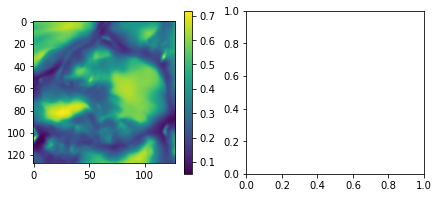

In [11]:
'''
Go through MURaM test set to find image idxs corresponding to MURaM time-series test set image 58
    WHY IS THERE NO MATCH?!?
'''

ts_im_58 = np.load('../../WNet_runs/exp34nm/test_preds_MURaM/x_58.npy')[0] # should really not be sacing test set with each model but oh well
fig, axs = plt.subplots(1,2,figsize=(7, 3)); img = axs[0].imshow(ts_im_58); plt.colorbar(img, ax=axs[0])

# files = os.listdir('../../WNet_runs/exp29nm/test_preds_MURaM/')
# idx = np.random.choice(np.linspace(0,len(files)+1,len(files)+1,dtype=int))
# im = np.load(f'../../WNet_runs/exp29nm/test_preds_MURaM/{files[idx]}')[0]
# print(files[idx])
# img = axs[1].imshow(im); plt.colorbar(img, ax=axs[1])

all_ims = [f for f in os.listdir('../../WNet_runs/exp29nm/test_preds_MURaM') if 'x_' in f]
print(f'Searching through {len(all_ims)} images for match')
for f in all_ims:
    im = np.load(f'../../WNet_runs/exp29nm/test_preds_MURaM/{f}')[0]
    if np.all(im == ts_im_58):
        print(f'Image {f} seems to match')
        plt.figure(); img = plt.imshow(im); plt.colorbar(img)
print('DONE')

From imset 011070to011470_7.npy FOUND middle 011270__7.npy in val
From imset 011070to011470_0.npy FOUND middle 011270__0.npy in val
From imset 007380to007780_8.npy FOUND middle 007580__8.npy in val
From imset 004100to004500_1.npy FOUND middle 004300__1.npy in val
From imset 011070to011470_1.npy FOUND middle 011270__1.npy in val
Timeseries file 011070to011470_7.npy
Middle image is 011270__7.npy which is in val folder in the non-TS set


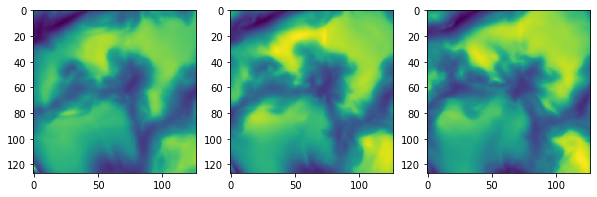

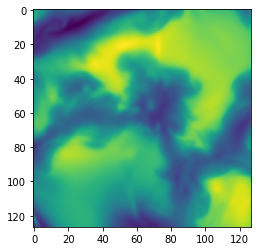

In [15]:
'''
Check that there are matches when pulling directly from data dirs
Yep
'''

val_files = os.listdir('../../Data/UNetData_MURaM/norm_images/val/')
trn_files = os.listdir('../../Data/UNetData_MURaM/norm_images/train/')
all_ts_val_files = os.listdir('../../Data/UNetData_MURaM_TSeries40/norm_images/val/') 
for tsfile in all_ts_val_files:#['000130to005130_0.npy']:
    loc = tsfile[tsfile.find('_')+1:-4]
    # name0 = f"{tsfile[0:tsfile.find('to')]}__{loc}.npy"; name40 = f"{tsfile[tsfile.find('to')+2:-6]}__{loc}.npy"
    # if name0 in val_files:# or name0 in trn_files: #or name40 in val_files or name40 in trn_files:
    #     print(f'From imset {tsfile} FOUND first {name0} in val')# (../../Data/UNetData_MURaM/norm_images/val/{name0} exists = {os.path.exists(f"../../Data/UNetData_MURaM/norm_images/val/{name0}")})')
    name_mid =  f"{str((int(tsfile[0:tsfile.find('to')])+200)).zfill(6)}__{loc}.npy"
    if name_mid in val_files:# or name0 in trn_files: #or name40 in val_files or name40 in trn_files:
        print(f'From imset {tsfile} FOUND middle {name_mid} in val')
        
'''
Check for one image set
'''
# all_ts_val_files = [os.listdir('../../Data/UNetData_MURaM_TSeries40/norm_images/val/')
# idx = np.random.choice(np.linspace(0,len(all_ts_val_files)-1,len(all_ts_val_files)-1,dtype=int))
tsfile = '011070to011470_7.npy' # all_ts_val_files[1]
tsim = np.load(f'../../Data/UNetData_MURaM_TSeries40/norm_images/val/{tsfile}')
fig, axs = plt.subplots(1, 3, figsize=(10,3))
axs[0].imshow(tsim[0]); axs[1].imshow(tsim[20]); axs[2].imshow(tsim[40])
loc = tsfile[tsfile.find('_')+1:-4]
name_mid =  f"{str((int(tsfile[0:tsfile.find('to')])+200)).zfill(6)}__{loc}.npy"
print(f'Timeseries file {tsfile}')

if os.path.exists(f'../../Data/UNetData_MURaM/norm_images/val/{name_mid}'): folder0 = 'val'
elif os.path.exists(f'../../Data/UNetData_MURaM/norm_images/train/{name_mid}'): folder0 = 'train'
else: folder0 = 'NO'
print(f'Middle image is {name_mid} which is in {folder0} folder in the non-TS set')

mid_image = np.load(f'../../Data/UNetData_MURaM/norm_images/{folder0}/{name_mid}')
plt.figure(); plt.imshow(mid_image)

True
Image exp29nm/test_preds_MURaM/x_439.npy matches UNetData_MURaM/norm_images/val/011270__7.npy


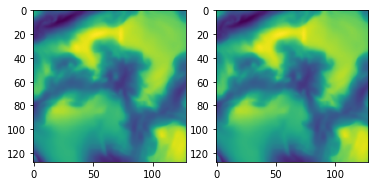

In [4]:
'''
So above TS set has target image that has a corresponding non-TS image
Lets find what idx these are in TS and non-TS test loaders - WHY IS IT NOT IN TS SET???
'''
import torchvision.transforms as transforms
resize = transforms.Resize(128, antialias=None)

# Load 011270__7.npy from non-TS set 
mid_image = np.load(f'../../Data/UNetData_MURaM/norm_images/val/011270__7.npy')
mid_image = mid_image.newbyteorder().byteswap() 
mid_image = np.array(resize(torch.from_numpy(np.expand_dims(mid_image, axis=0)))).squeeze() # to mock data loader

# # Load 011270__7.npy from the middle of TS set 011070to011470_7.npy
# tsim = np.load(f'../../Data/UNetData_MURaM_TSeries40/norm_images/val/011070to011470_7.npy')
# mid_image2 = tsim[2] #; mid_image = mid_image.newbyteorder().byteswap() 
# mid_image2 = np.array(resize(torch.from_numpy(np.expand_dims(mid_image, axis=0)))).squeeze() # to mock data loader
# print(np.all(mid_image == mid_image2))

all_files = [f for f in os.listdir('../../WNet_runs/exp29nm/test_preds_MURaM') if 'x_' in f]
for f in all_files:
    im = np.load(f'../../WNet_runs/exp29nm/test_preds_MURaM/{f}')[0]
    if np.all(im == mid_image):
        print(f'Image exp29nm/test_preds_MURaM/{f} matches UNetData_MURaM/norm_images/val/011270__7.npy')
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(mid_image); axs[1].imshow(im)

all_sets = [f for f in os.listdir('../../WNet_runs/exp34nm/test_preds_MURaM') if 'x_' in f]
for f in all_sets:
    im = np.load(f'../../WNet_runs/exp34nm/test_preds_MURaM/{f}')[2]
    found = False
    if np.all(im == mid_image):
        found = True
        print(f'Middle image of exp34nm/test_preds_MURaM/{f} matches UNetData_MURaM/norm_images/val/011270__7.npy')
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(mid_image); axs[1].imshow(im)
    if found = False:
        print(f'Middle image of exp34nm/test_preds_MURaM/{f} does not match any image in UNetData_MURaM/norm_images/val/')


FOUND: seg from TS test set true_15.npy matches non-TS test set seg true_439.npy
FOUND: seg from TS test set true_43.npy matches non-TS test set seg true_679.npy
FOUND: seg from TS test set true_60.npy matches non-TS test set seg true_611.npy
FOUND: seg from TS test set true_108.npy matches non-TS test set seg true_692.npy
FOUND: seg from TS test set true_68.npy matches non-TS test set seg true_274.npy


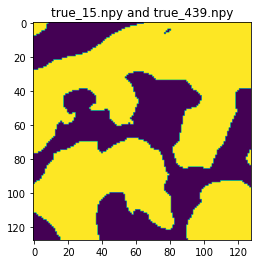

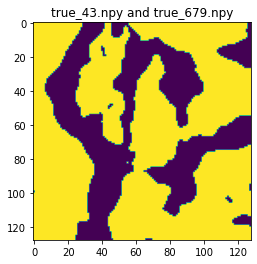

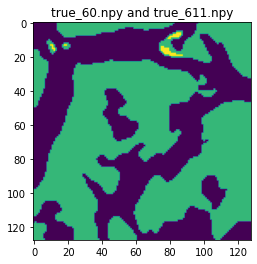

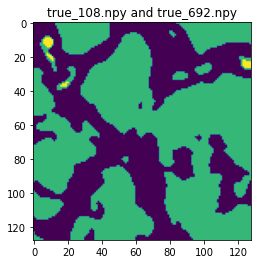

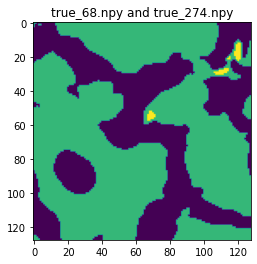

In [43]:
'''
Try picking TS set that has good targ image, then finding that in non-TS val set?
And lets try matching alg segs in case I have a normalization error or something
'''
# good_TS_set = '../../WNet_runs/MURaM/WNetT_1A/test_preds_MURaM/x_58.npy'
# good_TS_img = np.squeeze(np.load(good_TS_set))[2]

all_TSfiles = [f for f in os.listdir('../../WNet_runs/MURaM/WNetT_1A/test_preds_MURaM/') if 'true_' in f]# all_TS_sets = [f for f in os.listdir('../../WNet_runs/MURaM/WNetT_1A/test_preds_MURaM/') if 'x_' in f]
all_files = [f for f in os.listdir('../../WNet_runs/MURaM/WNetX_1A/test_preds_MURaM') if 'true_' in f]
for s in all_TSfiles: #all_TS_sets:
    ts_im = np.squeeze(np.load(f'../../WNet_runs/MURaM/WNetT_1A/test_preds_MURaM/{s}')) #ts_set = np.squeeze(np.load(f'../../WNet_runs/MURaM/WNetT_1A/test_preds_MURaM/{s}'))
    for f in all_files:
        im = np.squeeze(np.load(f'../../WNet_runs/MURaM/WNetX_1A/test_preds_MURaM/{f}'))
        #fig, axs = plt.subplots(1, 2); tsim = axs[0].imshow(ts_im); plt.colorbar(tsim, ax=axs[0]); im = axs[1].imshow(im); plt.colorbar(im, ax=axs[1]); a=b
        if np.all(im == ts_im):
            print(f'FOUND: seg from TS test set {s} matches non-TS test set seg {f}')
            plt.figure(); plt.imshow(im); plt.title(f'{s} and {f}')


False
False
True
[0.14619401 0.14816968 0.22745378 ... 0.17262161 0.3854456  0.4868008 ]
[0.146194   0.14816967 0.22745377 ... 0.1726216  0.38544556 0.48680082]


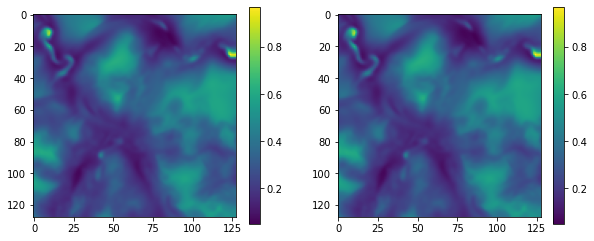

In [41]:
'''
Ok so TS seg WNetT_1A/test_preds_MURaM/true_108.npy matches non-TS seg WNetX_1A/test_preds_MURaM/true_692.npy
    and TS seg WNetT_1A/test_preds_MURaM/true_68.npy matches non-TS seg WNetX_1A/test_preds_MURaM/true_274.npy
Why don't the corresponding targ imgs match?
    Oh... they do but there's just like rounding errors or something
'''

ts_targim = np.squeeze(np.load('../../WNet_runs/MURaM/WNetT_1A/test_preds_MURaM/x_108.npy'))[2]
nonts_im = np.squeeze(np.load('../../WNet_runs/MURaM/WNetX_1A/test_preds_MURaM/x_692.npy')) 
print(np.all(ts_targim == nonts_im))
print((ts_targim == nonts_im).all())
print(np.sum(ts_targim) == np.sum(nonts_im))
diff_idx = np.where(ts_targim != nonts_im)
print(ts_targim[diff_idx])
print(nonts_im[diff_idx])

fig, axs = plt.subplots(1,2, figsize=(10,4))
tsim = axs[0].imshow(ts_targim); plt.colorbar(tsim, ax=axs[0])
im = axs[1].imshow(nonts_im); plt.colorbar(im, ax=axs[1])

1801 raw imgs, 1801 incorrectly normed imgs, 1801 new normed imgs


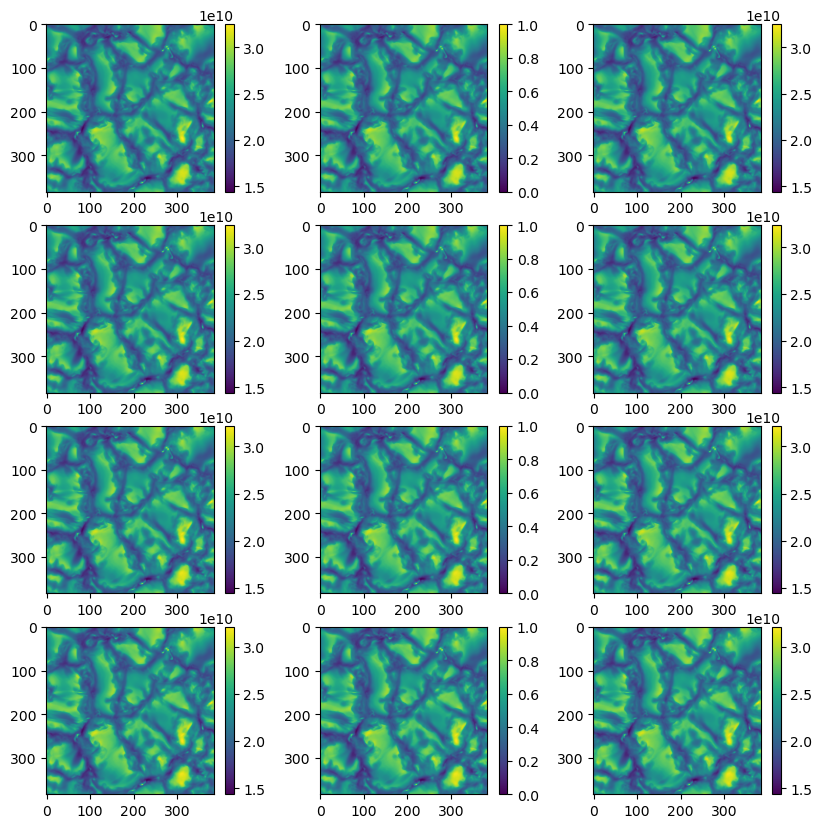

In [9]:
'''
Re-done normalizations
'''

raw_files = np.sort([f for f in os.listdir('../../Data/MURaM') if f.startswith('I')])
norm_files_bad = np.sort([f for f in os.listdir('../../Data/MURaM') if f.startswith('Norm')])
norm_files_good = np.sort([f for f in os.listdir('../../Data/MURaM') if f.startswith('fullNorm')])

print(f'{len(raw_files)} raw imgs, {len(norm_files_bad)} incorrectly normed imgs, {len(norm_files_good)} new normed imgs')
fig, axs = plt.subplots(4, 3, figsize=(10,10))
for i in range(4):
    im0 = axs[i,0].imshow(fits.open(f'../../Data/MURaM/{raw_files[i]}')[0].data); plt.colorbar(im0, ax=axs[i,0])
    im1 = axs[i,1].imshow(fits.open(f'../../Data/MURaM/{norm_files_bad[i]}')[0].data); plt.colorbar(im1, ax=axs[i,1])   
    im2 = axs[i,2].imshow(fits.open(f'../../Data/MURaM/{norm_files_good[i]}')[0].data); plt.colorbar(im2, ax=axs[i,2])

#### MISC

In [12]:
'''
Create UNetData_v2_subset/seg_images_binary anologous to UNetData_v2_subset/seg_images
'''

# dir = "../Data/UNetData_v2_subset/"
# for file in os.listdir(f'{dir}seg_images/train/'):
#     if os.path.exists(f'{dir}seg_images_binary/train/{file}') == False:
#         seg = np.load(f'{dir}seg_images/train/{file}')
#         binseg = funclib.convert_back(seg, to='binary')
#         np.save(f'{dir}seg_images_binary/train/{file}', binseg)
# for file in os.listdir(f'{dir}seg_images/val/'):
#     if os.path.exists(f'{dir}seg_images_binary/val/{file}') == False:
#         seg = np.load(f'{dir}seg_images/val/{file}')
#         binseg = funclib.convert_back(seg, to='binary')
#         np.save(f'{dir}seg_images_binary/val/{file}', binseg)

'\nCreate UNetData_v2_subset/seg_images_binary anologous to UNetData_v2_subset/seg_images\n'

In [ ]:
'''
Going back to using just first light, but lets also do it on only 3 classes. 
Create UNetData_v2_subset/seg_images_ternary anologous to UNetData_v2_subset/seg_images
'''

# dir = "../Data/UNetData/"
# for file in os.listdir(f'{dir}seg_images/train/'):
#     if os.path.exists(f'{dir}seg_images_ternary/train/{file}') == False:
#         seg = np.load(f'{dir}seg_images/train/{file}')
#         triseg = funclib.convert_back(seg, to='ternary')
#         np.save(f'{dir}seg_images_ternary/train/{file}', triseg)
# for file in os.listdir(f'{dir}seg_images/val/'):
#     if os.path.exists(f'{dir}seg_images_ternary/val/{file}') == False:
#         seg = np.load(f'{dir}seg_images/val/{file}')
#         triseg = funclib.convert_back(seg, to='ternary')
#         np.save(f'{dir}seg_images_ternary/val/{file}', triseg)

In [ ]:
d = json.load(open('../exp_file.json','rb'))
print(d['randomSharp'])
if d['randomSharp'] == False: print('yes, its false')

In [10]:
'''
Move exp dicts from exp_dict.json to seperate files for all nm models
'''
import json


# d = {"WNet_name": "WNet31nm",
#     "n_classes": 3,
#     "channels": ["X","median_residual"],
#     "weights": [1,1],
#     "img_dir": "../Data/UNetData_MURaM/norm_images/",
#     "seg_dir": "../Data/UNetData_MURaM/seg_images/",
#     "img_size": 128,
#     "randomSharp": "False",
#     "smooth_loss": "True",
#     "blob_loss": "False",
#     "smooth_wght": 10,
#     "blob_wght": 0,
#     "ncut_wght": 1,
#     "padding_mode": "reflect",
#     "num_epochs": 10, 
#     "num_sup": 0, 
#     "freeze_dec": "False",
#     "batch_size": 16,
#     "learning_rate": 0.1}
# json.dump(d, open('../../WNet_runs/exp31nm/exp_file.json','w'))

d = {
  "WNet_name": "WNet32nm",
  "n_classes": 3,
  "channels": [
   "X",
   "median_residual"
  ],
  "weights": [
   1,
   1
  ],
  "img_dir": "../Data/UNetData_MURaM/norm_images/",
  "seg_dir": "../Data/UNetData_MURaM/seg_images/",
  "img_size": 128,
  "randomSharp": "False",
  "smooth_loss": "True",
  "blob_loss": "False",
  "smooth_wght": 10,
  "blob_wght": 0,
  "ncut_wght": 1,
  "padding_mode": "replicate",
  "num_epochs": 10,
  "num_sup": 0,
  "freeze_dec": "False",
  "batch_size": 16,
  "learning_rate": 0.1
 }
json.dump(d, open('../../WNet_runs/exp32nm/exp_file.json','w'))

# d = {"WNet_name": "WNet33nm",
#     "n_classes": 3,
#     "channels": ["X"],
#     "weights": [1],
#     "img_dir": "../Data/UNetData_MURaM/norm_images/",
#     "seg_dir": "../Data/UNetData_MURaM/seg_images/",
#     "img_size": 128,
#     "randomSharp": "False",
#     "smooth_loss": "True",
#     "blob_loss": "False",
#     "smooth_wght": 10,
#     "blob_wght": 0,
#     "ncut_wght": 1,
#     "padding_mode": "replicate",
#     "num_epochs": 10, 
#     "num_sup": 0, 
#     "freeze_dec": "False",
#     "batch_size": 16,
#     "learning_rate": 0.1}
# json.dump(d, open('../../WNet_runs/exp33nm/exp_file.json','w'))

d = {
    "WNet_name": "WNet34nm",
    "n_classes": 3,
    "channels": ["timeseries40_5"],
    "weights": [1,1,1,1,1],
    "img_dir": "../Data/UNetData_MURaM_TSeries40/norm_images/",
    "seg_dir": "../Data/UNetData_MURaM_TSeries40/seg_images/",
    "img_size": 128,
    "randomSharp": "False",
    "smooth_loss": "True",
    "blob_loss": "False",
    "smooth_wght": 10,
    "blob_wght": 0,
    "ncut_wght": 1,
    "padding_mode": "replicate",
    "num_epochs": 10, 
    "num_sup": 0, 
    "freeze_dec": "False",
    "batch_size": 16,
    "learning_rate": 0.1
 }
json.dump(d, open('../../WNet_runs/exp34nm/exp_file.json','w'))


In [8]:
'''
Ensure random train-test split when keeping test imgs together
'''

data = np.linspace(0,2000,2000).reshape(20, 10, 10)
test_idxs = np.random.choice(np.linspace(0, data.shape[0]-1, data.shape[0]), int(data.shape[0]*0.4))
data_train = []
data_test = []
for i in range(data.shape[0]):
    if i in test_idxs:
        data_test.append(data[i])
    else:
        data_train.append(data[i])
data_train = np.array(data_train)
data_test = np.array(data_test)
print(data_train.shape, data_test.shape)

train_sub_idxs = np.random.choice(np.linspace(0, len(data_train)-1, len(data_train), dtype=int), 10)
data_train_sub = []
for idx in train_sub_idxs:
    data_train_sub.append(data_train[idx])
data_train_sub = np.array(data_train_sub)
print(data_train_sub.shape)


(14, 10, 10) (6, 10, 10)
(10, 10, 10)


In [19]:
n = 180
test_idxs = np.random.choice(np.linspace(0, n, n+1, dtype=int), int(n+1*0.4), replace=False)
print(len(test_idxs))
print(np.sort(test_idxs))
used_test_idxs = []
for i in range(n):
    if i in test_idxs:
        used_test_idxs.append(i)
print(len(used_test_idxs))
print(used_test_idxs)

180
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 170 171 172 173 174 175 176 177 178 179 180]
179
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67

In [5]:
files = [f for f in os.listdir('../../Data/UNetData_MURaM_TSeries20/') if '.npy' in f]
for file in files:
    os.remove('../../Data/UNetData_MURaM_TSeries20/'+file)

In [11]:
files = [f for f in os.listdir('../../../Jobs') if 'Job' in f]
for f in files:
    tag = f[4:-4]
    if int(tag) < 7900992:
        os.remove('../../../Jobs/'+f)

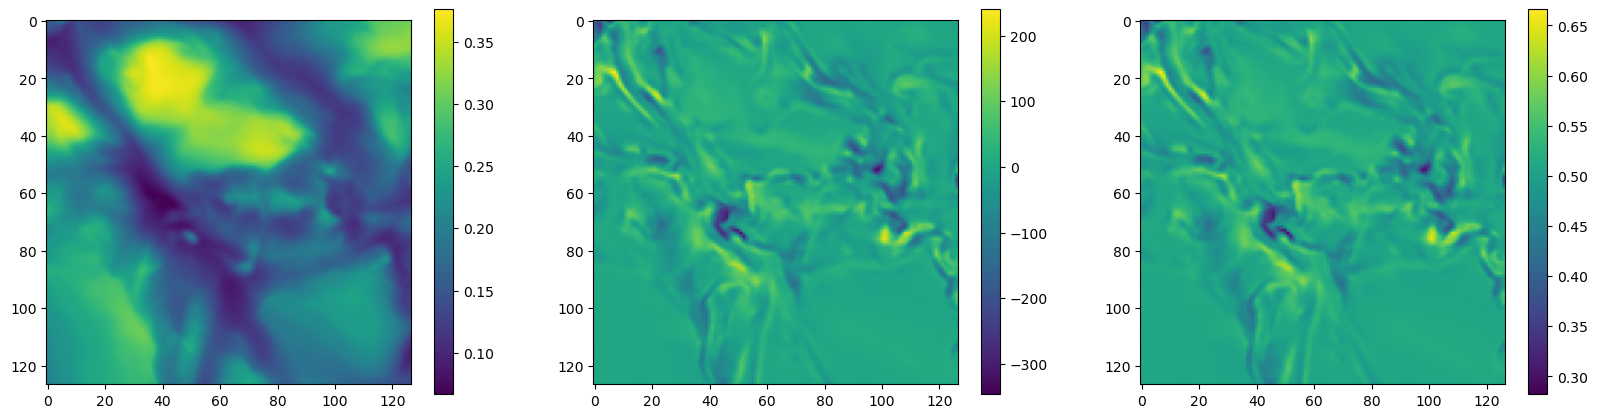

In [5]:
'''
Check normalized mag images 
'''
norm_mags = os.listdir('../../Data/UNetData_MURaM/fullnorm_mag_images')
old_mags = os.listdir('../../Data/UNetData_MURaM/mag_images_bad')
imgs = os.listdir('../../Data/UNetData_MURaM/fullnorm_images')
fig, axs = plt.subplots(1,3, figsize=(20,5))
im0 = axs[0].imshow(np.load(f'../../Data/UNetData_MURaM/fullnorm_images/{imgs[0]}')); plt.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(np.load(f'../../Data/UNetData_MURaM/mag_images_bad/{old_mags[0]}')); plt.colorbar(im1, ax=axs[1])
im2 = axs[2].imshow(np.load(f'../../Data/UNetData_MURaM/fullnorm_mag_images/{norm_mags[0]}')); plt.colorbar(im2, ax=axs[2])


In [8]:
'''
Move velocity imgs
'''

# files =  [f for f in os.listdir('../../Data/') if '_vx.fits' in f]
# for file in files:
#     shutil.move(f'../../Data/{file}', f'../../Data/MURaM_vx/{file}')

# files =  [f for f in os.listdir('../../Data/') if '_vy.fits' in f]
# for file in files:
#     shutil.move(f'../../Data/{file}', f'../../Data/MURaM_vy/{file}')
    
files =  [f for f in os.listdir('../../Data/') if '_vz.fits' in f]
for file in files:
    shutil.move(f'../../Data/{file}', f'../../Data/MURaM_vz/{file}')

In [ ]:
'''
Why is UNetData_MURaM/fullnorm_images/000210__0.npy not getting loaded when making TS?
'''

# It *is* in initial data set (and same if look at fullNorm_I_out in og dir)
raw_imgdir = '../../Data/MURaM/'
raw_imgfiles = np.sort([f for f in os.listdir(raw_imgdir) if f.startswith('I_out')])
print(f'First 20 imgs in OG dir\n{raw_imgfiles[0:22]}')

# # But in making subsections have skipped some.. n00021, 00013, 00016 (same for both 'fullnorm_images' and 'images')..
# subsecdir = '../../Data/UNetData_MURaM/fullnorm_images'
# normimgs_region = np.sort([f for f in os.listdir(subsecdir) if '_0' in f])
# print(f'First 20 imgs of region 0 in subsections dir\n{normimgs_region[0:22]}')

# a=b
# # Which are missing? Yeah.. 13, 16, 21
# imgs = os.listdir('../../Data/UNetData_MURaM/images/')
# print('Subsections were not save for"')
# for i in range(24): # og imgs go from I_out.000000.fits.gz to I_out.018000.fits.gz
#     tag = "{:06d}".format(i*10)
#     if len([f for f in imgs if tag in f]) == 0:
#         print(f'   file {tag}')
        
# Code that produced saved subsections (this is for normed, but clearly issue is same for non-normed)
n = 3
norm_tag = 'full'
normfiles = [file for file in os.listdir(raw_imgdir) if file.startswith(f'{norm_tag}Norm')] # files = [fil for file in os.listdir(OG_dir) if file.startswith('Norm_VBI') and file.endswith('_4096') and not any(tag in file for tag in ['31_21', '33_13', '04_29', '17_20', '24_26'])]   
pad = int(np.shape(fits.open(f'{raw_imgdir}/{raw_imgfiles[0]}')[0].data)[0]/200)
print(f'Saving subsections for {len(normfiles)} files', flush=True)
for file in normfiles:
    tag = file[file.find('out')+4: file.find('.fits')]
    if os.path.exists(f'{subsecdir}/{tag}__{n**2-1}.npy'): # last .npy created from normfile
        print(f'\tNormed file {file} (tag {tag}) --> subsections already saved', flush=True)
    elif os.path.exists(f'{subsecdir}/train/{tag}__{n**2-1}.npy') or os.path.exists(f'{subsecdir}/val/{tag}__{n**2-1}.npy'): # last .npy created from normfile
        print(f'\tNormed file {file} (tag {tag}) --> subsections already saved and split into train/test', flush=True)
    else:
        #print(f'{subsecdir}/{tag}__{n**2-1}.npy DNE');a=b
        print(f'\tNormed file {file} (tag {tag}) --> saving subsections', flush=True)

753 in train
12 in val
Should in total be 1801 raw imgs x 9 subsec regions / 21.0 imgs per set = 771.8571428571429


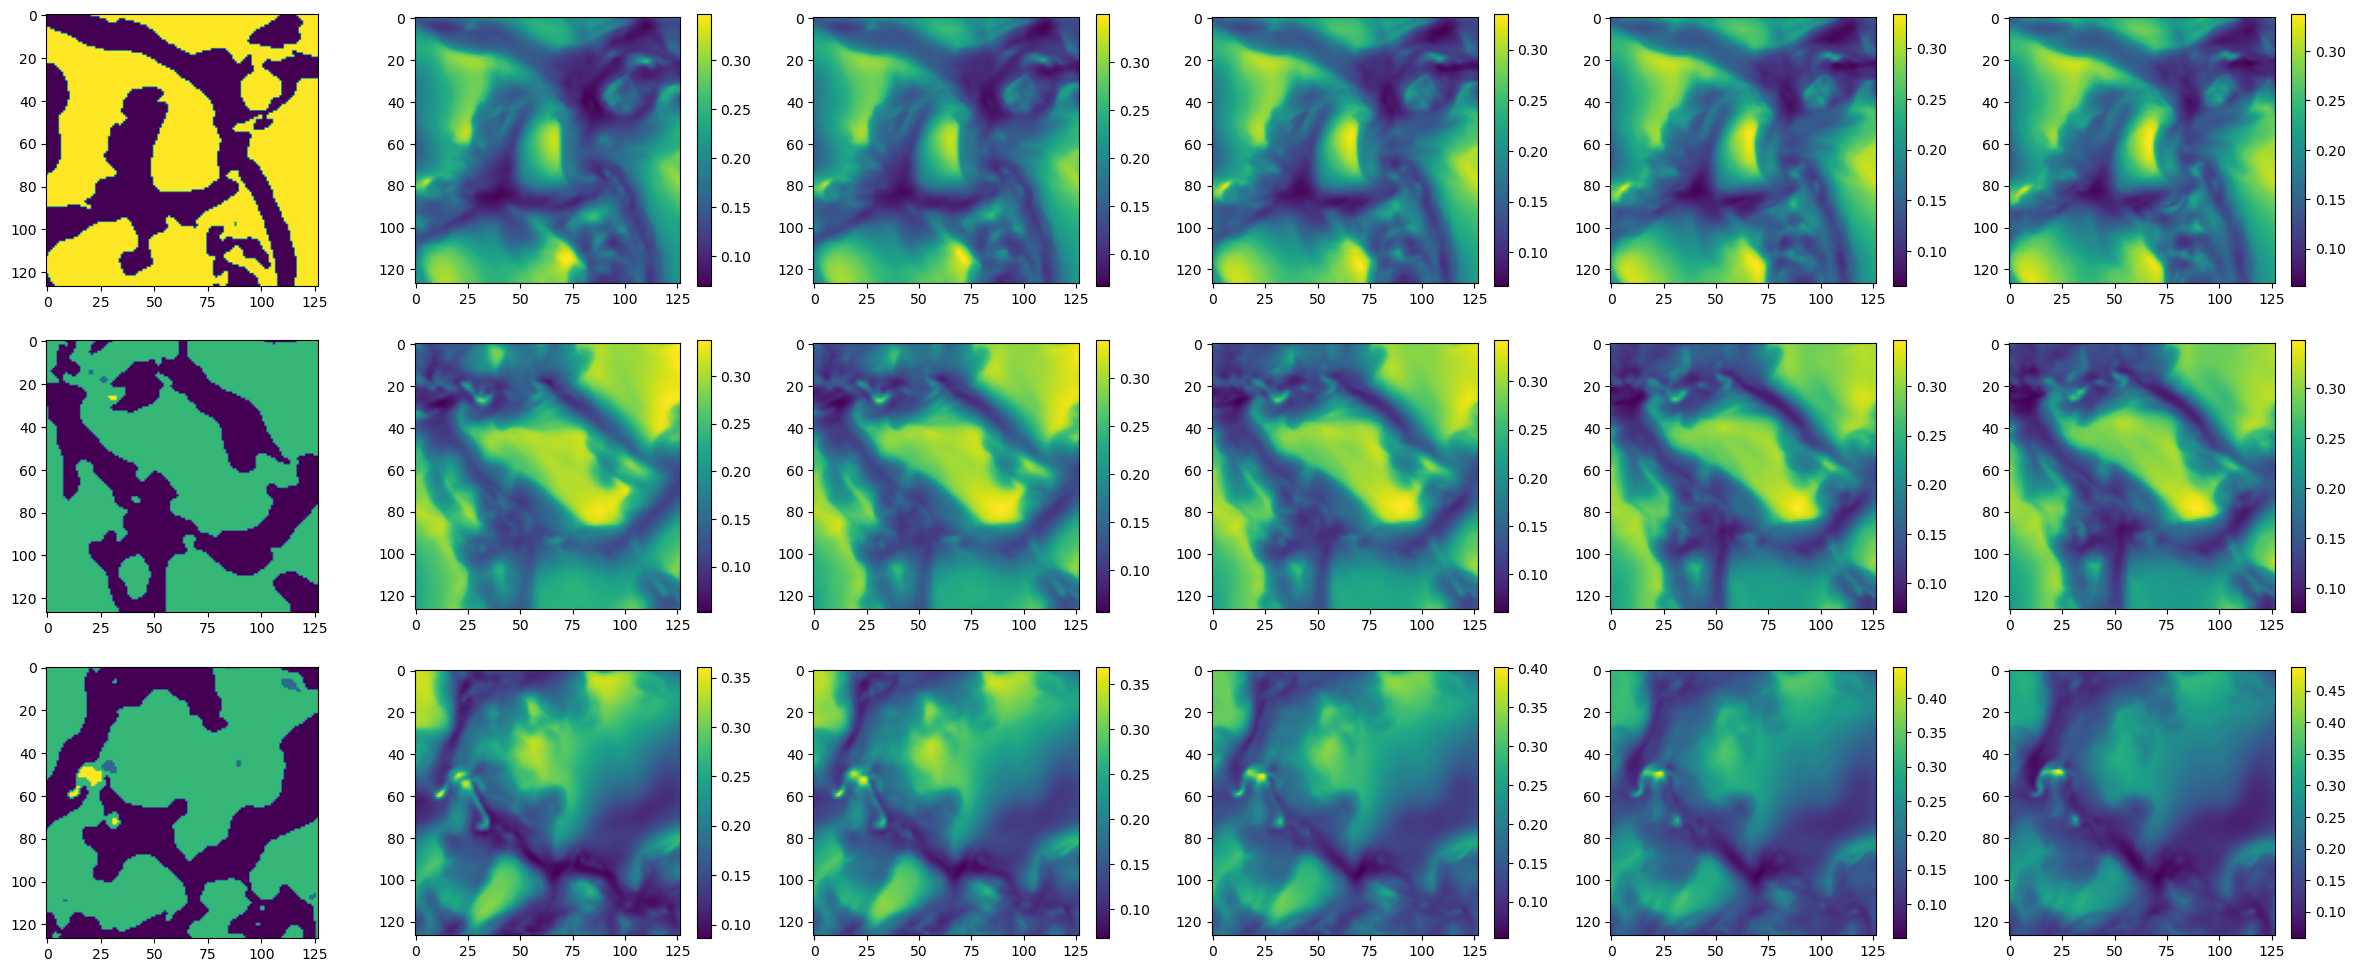

In [8]:
'''
Check new T series
 - Why did I have so many more with non-fullnorm set???
'''

s = 40
imgs = np.sort(os.listdir(f'../../Data/UNetData_MURaM_TSeries{s}/fullnorm_images/train/'))
segs = np.sort(os.listdir(f'../../Data/UNetData_MURaM_TSeries{s}/seg_images/train/'))
N = 3
fig, axs = plt.subplots(N, 6, figsize=(30, N*4))
for i in range(N):
    imgset = np.load(f'../../Data/UNetData_MURaM_TSeries{s}/fullnorm_images/train/{imgs[i]}')
    seg = np.load(f'../../Data/UNetData_MURaM_TSeries{s}/seg_images/train/{segs[i]}')
    axs[i,0].imshow(seg)
    for j in range(5):
        im = axs[i,j+1].imshow(imgset[j*4]); plt.colorbar(im, ax=axs[i,j+1])
print(f'{len(os.listdir(f"../../Data/UNetData_MURaM_TSeries{s}/fullnorm_images/train/"))} in train')
print(f'{len(os.listdir(f"../../Data/UNetData_MURaM_TSeries{s}/fullnorm_images/val/"))} in val')
raw_imgs = [f for f in os.listdir('../../Data/MURaM/') if 'fullNorm' in f]
size = (s/2) + 1
print(f'Should in total be {len(raw_imgs)} raw imgs x 9 subsec regions / {size} imgs per set = {len(raw_imgs)*9/size}')

In [29]:
s = 40
imgs = np.sort(os.listdir(f'../../Data/UNetData_MURaM_TSeries{s}/fullnorm_images/train/'))
segs = np.sort(os.listdir(f'../../Data/UNetData_MURaM_TSeries{s}/seg_images/train/'))
for i in range(len(imgs)):
    start = imgs[i][0:6]
    end = imgs[i][8:14]
    region = imgs[i][15]
    segstamp = "{:06d}".format(int(start)+int((int(end)-int(start))/2))
    seg_name = f'SEG_{segstamp}__{region}.npy'                                                                  
    if seg_name != segs[i]:
        print(f'imgs[i] {imgs[i]} gives start {start}, end {end}, makes seg_name {seg_name} != segs[i] {segs[i]}')

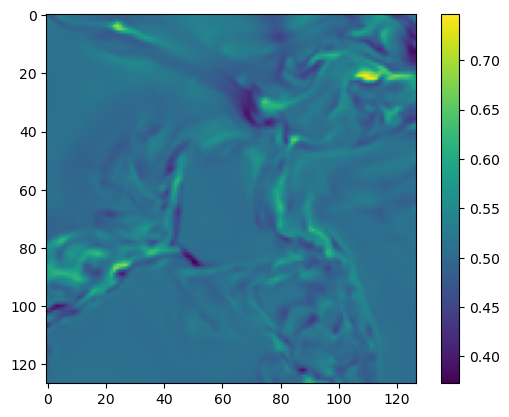

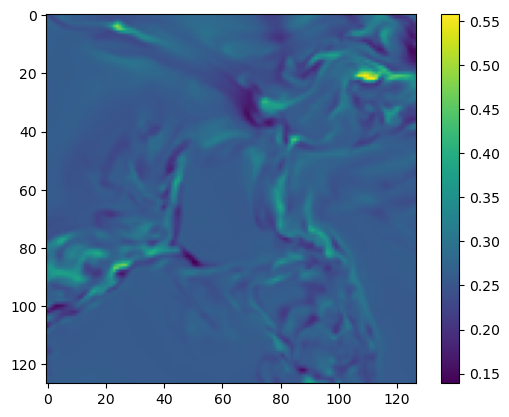

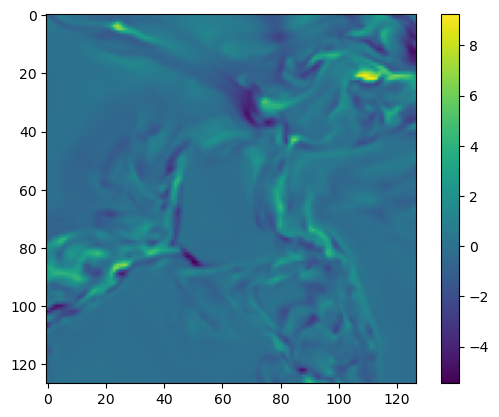

In [3]:
'''
Should I sqaure mag? Should I be normalizing it to std normal even after normalizing all mag imgs by full series min/max?
'''

mag = np.load('../../Data/UNetData_MURaM/fullnorm_mag_images/train/000000__0.npy') #'/UNetData_MURaM/{norm_tag}norm_mag_images/{set}/{image_name}'
plt.figure(); im = plt.imshow(mag); plt.colorbar(im)
plt.figure(); im = plt.imshow(mag**2); plt.colorbar(im)
plt.figure(); im = plt.imshow((mag - np.mean(mag))/np.std(mag)); plt.colorbar(im)

In [24]:
'''
Check lengths of new sets
'''
print(f'{len(os.listdir(f"../../Data/UNetData_MURaM/fullnorm_images/train/"))} imgs in train')
print(f'{len(os.listdir(f"../../Data/UNetData_MURaM/fullnorm_images/val/"))} imgs in val')
raw_imgs = [f for f in os.listdir('../../Data/MURaM/') if 'fullNorm' in f]
print(f'Should in total be {len(raw_imgs)} raw imgs x 9 subsec regions = {len(raw_imgs)*9}')


ms = ['WNetMfn_1E', 'WNetMfn_1F', 'WNetMfn_1G', 'WNetTfn_1A', 'WNetTfn_1D', 'WNetTfn_2C', 'WNetXfn_1Ba', 'WNetXfn_2B', 'WNetXfn_3A', 'WNetXfn_3B', 'WNetXfn_bin1A', 'WNetXfn_bin1C', 'WNetXfn_bin1D']
for m in  ms:
    if 'T' not in m:
        x_imgs = [f for f in os.listdir(f'../../model_runs_seg/MURaM/{m}/test_preds_MURaM/') if 'x' in f]
        if len(x_imgs) != 4781:
            print(f'Hmm... only {len(x_imgs)} imgs in val folder for {m} (should be 4781)')

11428 imgs in train
4781 imgs in val
Should in total be 1801 raw imgs x 9 subsec regions = 16209


In [25]:
'''
See if img I was using as good val example for individual norm set is also in full norm val set 
'''

idx =  692
img = np.load(f'../../model_runs_seg/MURaM/WNetX_1A/test_preds_MURaM/x_{idx}.npy')[0]
fn_pred_imgs = [f for f in os.listdir("../../model_runs_seg/MURaM/WNetXfn_1A/test_preds_MURaM") if 'x' in f]
for f in fn_pred_imgs:
    fn_img = np.load(f"../../model_runs_seg/MURaM/WNetXfn_1A/test_preds_MURaM/{f}")
    if np.sum(img.flatten()) == np.sum(fn_img.flatten()):
        print(f'{f} matches')

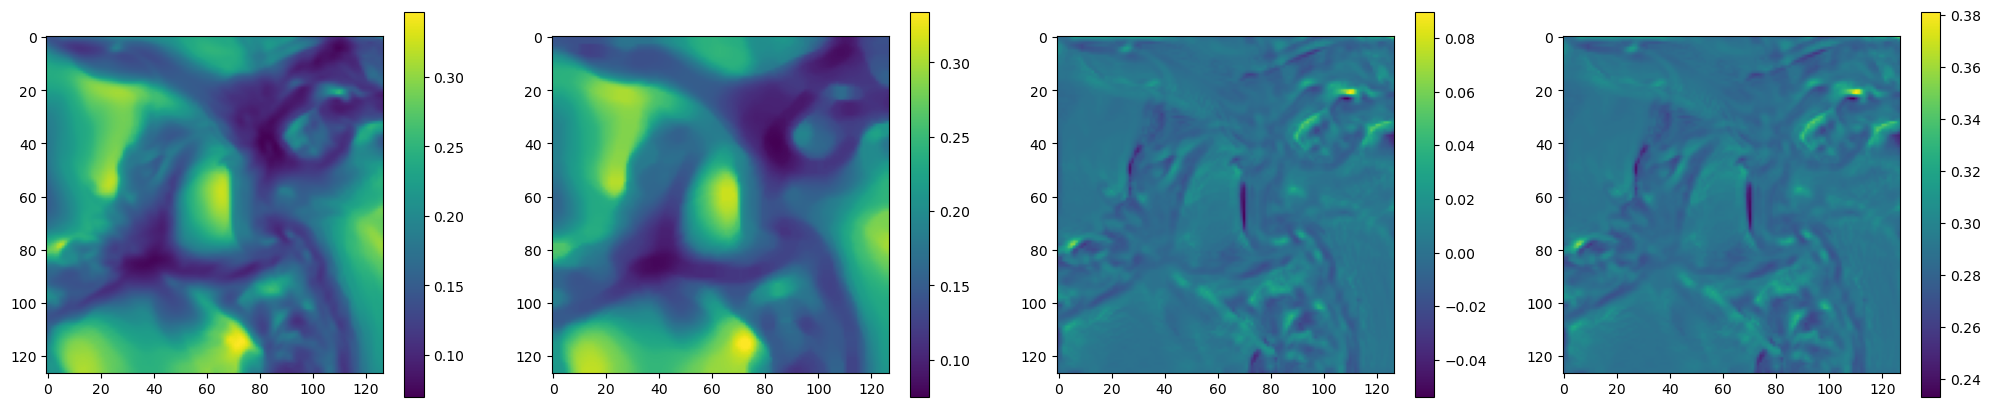

In [14]:
'''
Why does median residual not look right in data loaders?
'''
img = np.load('../../Data/UNetData_MURaM/fullnorm_images/train/000000__0.npy')
med8 = np.load('../../Data/UNetData_MURaM/fullnorm_med8_images/train/med8_000000__0.npy')
fig, axs = plt.subplots(1, 4, figsize=(25, 5))
im0 = axs[0].imshow(img); plt.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(med8); plt.colorbar(im1, ax=axs[1])
res = img - med8
im2 = axs[2].imshow(res); plt.colorbar(im2, ax=axs[2])
full_min = -0.28 
full_max = 0.69
a = ((res - full_min)/(full_max - full_min))
im3 = axs[3].imshow(a); plt.colorbar(im3, ax=axs[3])

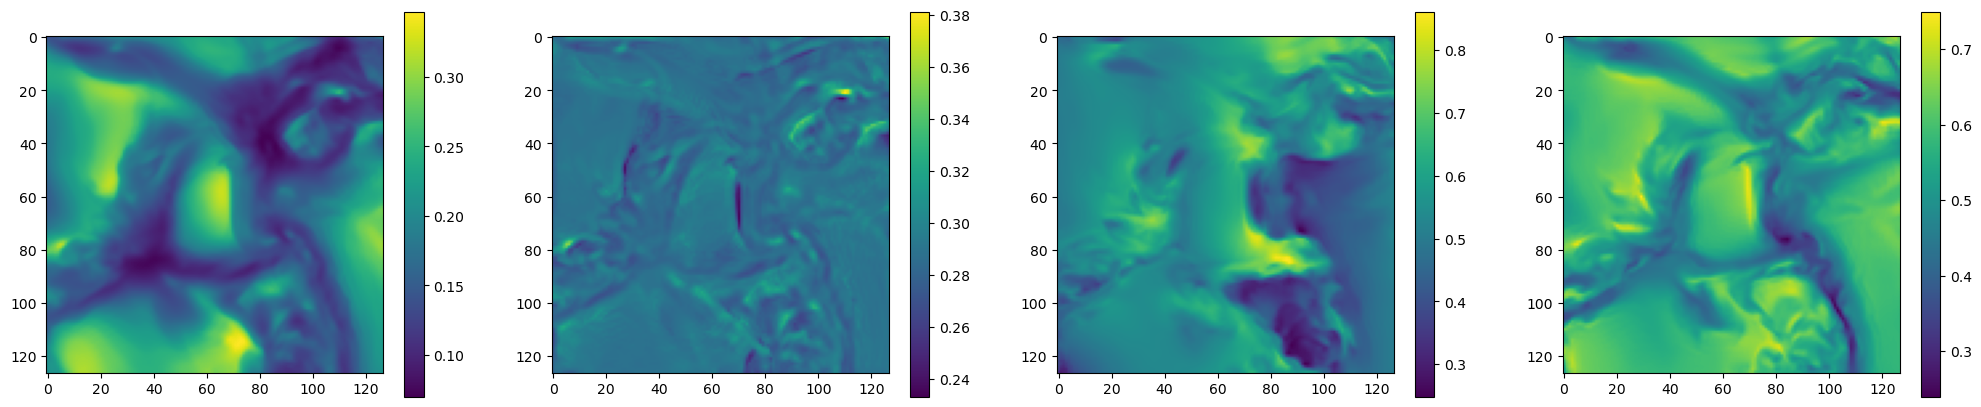

In [32]:
'''
Check med8, mag, and vel sets
'''

img = np.load('../../Data/UNetData_MURaM/fullnorm_images/train/000000__0.npy')
med8 = np.load('../../Data/UNetData_MURaM/fullnorm_med8_images/train/med8_000000__0.npy')
vx = np.load('../../Data/UNetData_MURaM/fullnorm_vx_images/train/000000__0.npy')
vz = np.load('../../Data/UNetData_MURaM/fullnorm_vz_images/train/000000__0.npy')
fig, axs = plt.subplots(1, 4, figsize=(25, 5))
im0 = axs[0].imshow(img); plt.colorbar(im0, ax=axs[0])
res = img - med8
full_min = -0.28 
full_max = 0.69
a = ((res - full_min)/(full_max - full_min))
im1 = axs[1].imshow(a); plt.colorbar(im1, ax=axs[1])
im2 = axs[2].imshow(vx); plt.colorbar(im2, ax=axs[2])
im3 = axs[3].imshow(vz); plt.colorbar(im3, ax=axs[3])

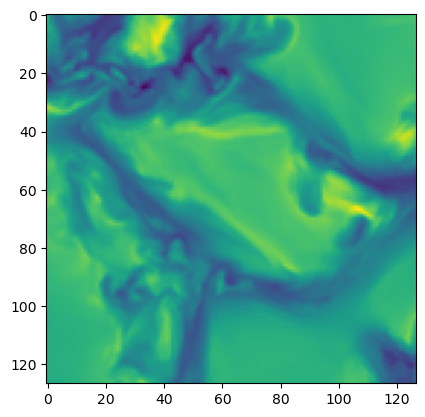

In [31]:
plt.imshow(np.load('../../Data/UNetData_MURaM/fullnorm_vz_images/train/000000__1.npy'))
#plt.imshow(fits.open('../../Data/MURaM_vz/fullNorm_tau_slice_1.000.012000_vz.fits.gz')[0].data)

In [12]:
'''
Clean out jobs dir
'''
keep_past = 8369287
for f in [f for f in os.listdir('../../../Jobs') if '.out' in f]:
    num = f[f.find('-')+1:f.find('.out')]
    if int(num) < keep_past:
        os.remove(f'../../../Jobs/{f}')


In [28]:
'''
Injecting masked bp images?
'''

images = os.listdir('.././../Data/UNetData_MURaM/fullnorm_images/train')


['mask_flag',
 '006420__0.npy',
 '015020__2.npy',
 '012250__8.npy',
 '016010__0.npy',
 'mask_flag',
 '007720__5.npy',
 '010290__7.npy',
 '016010__2.npy',
 '016470__3.npy',
 'mask_flag',
 '010980__1.npy',
 '008650__1.npy',
 '009150__0.npy',
 '015650__7.npy',
 'mask_flag',
 '009920__5.npy',
 '005550__3.npy',
 '017260__1.npy',
 '015710__2.npy',
 'mask_flag',
 '017600__2.npy',
 '007860__8.npy',
 '003170__4.npy',
 '005710__5.npy',
 'mask_flag',
 '004890__2.npy',
 '011390__7.npy',
 '017680__0.npy',
 '017890__4.npy',
 'mask_flag',
 '012900__1.npy',
 '008860__8.npy',
 '013060__8.npy',
 '014250__8.npy',
 'mask_flag',
 '006950__4.npy',
 '012340__8.npy',
 '006560__1.npy',
 '016990__1.npy',
 'mask_flag',
 '005930__4.npy',
 '004180__4.npy',
 '002820__7.npy',
 '017990__0.npy',
 'mask_flag',
 '015390__3.npy',
 '013140__0.npy',
 '008280__2.npy',
 '012520__6.npy',
 'mask_flag',
 '003410__1.npy',
 '000020__3.npy',
 '013700__2.npy',
 '008980__8.npy',
 'mask_flag',
 '016230__8.npy',
 '016410__5.npy',
 '01

In [2]:
import numpy as np
np.linspace(0,20-1,20)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.])